In [1]:

import itertools
import math
from collections import OrderedDict, Counter
from dataclasses import dataclass
from typing import Dict, Optional, Sequence, Tuple, List
from typing import Iterable

import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch_geometric
from pytorch_lightning import seed_everything
from rdkit import Chem
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torchhd import HRRTensor

from src.datasets.zinc_pairs import pyg_to_nx
from src.datasets.zinc_smiles_generation import ZincSmiles
from src.encoding.configs_and_constants import DatasetConfig, Features, FeatureConfig, IndexRange
from src.encoding.feature_encoders import CombinatoricIntegerEncoder
from src.encoding.graph_encoders import HyperNet, load_or_create_hypernet
from src.encoding.oracles import Oracle
from src.encoding.the_types import VSAModel
from src.utils.utils import GLOBAL_MODEL_PATH

"""
Features
    Atom types size: 9
    Atom types: ['Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']
    Degrees size: 5, encoded with 0 index:
    Degrees: {1, 2, 3, 4, 5}
    Formal Charges size: 3
    Formal Charges: {0, 1, -1}
    Explicit Hs size: 4
    Explicit Hs: {0, 1, 2, 3}
Encodings:
    float(ZINC_SMILE_ATOM_TO_IDX[atom.GetSymbol()]),
    float(atom.GetDegree() - 1),  # [1, 2, 3, 4, 5] -> [0, 1, 2, 3, 4]
    float(atom.GetFormalCharge() if atom.GetFormalCharge() >= 0 else 2),  # [0, 1, -1] -> [0, 1, 2]
    float(atom.GetTotalNumHs()),
"""

"\nFeatures\n    Atom types size: 9\n    Atom types: ['Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']\n    Degrees size: 5, encoded with 0 index:\n    Degrees: {1, 2, 3, 4, 5}\n    Formal Charges size: 3\n    Formal Charges: {0, 1, -1}\n    Explicit Hs size: 4\n    Explicit Hs: {0, 1, 2, 3}\nEncodings:\n    float(ZINC_SMILE_ATOM_TO_IDX[atom.GetSymbol()]),\n    float(atom.GetDegree() - 1),  # [1, 2, 3, 4, 5] -> [0, 1, 2, 3, 4]\n    float(atom.GetFormalCharge() if atom.GetFormalCharge() >= 0 else 2),  # [0, 1, -1] -> [0, 1, 2]\n    float(atom.GetTotalNumHs()),\n"

In [2]:
seed = 42

seed_everything(seed)
device = torch.device('cpu')
# ----- hypernet config (kept for provenance; not needed in this flow) -----
ds_name = "ZincSmilesHRR7744"
zinc_feature_bins = [9, 6, 3, 4]
dataset_config = DatasetConfig(
    seed=42,
    name=ds_name,
    vsa=VSAModel.HRR,
    hv_dim=88 * 88,
    device=device,
    node_feature_configs=OrderedDict(
        [
            (

                Features.ATOM_TYPE,
                FeatureConfig(
                    count=math.prod(zinc_feature_bins),
                    encoder_cls=CombinatoricIntegerEncoder,
                    index_range=IndexRange((0, 4)),
                    bins=zinc_feature_bins,
                ),
            ),
        ]
    ),
)

print("Loading/creating hypernet …")
hypernet: HyperNet = (
    load_or_create_hypernet(path=GLOBAL_MODEL_PATH, cfg=dataset_config).to(device=device)
)
print("Hypernet ready.")
assert not hypernet.use_edge_features()
assert not hypernet.use_graph_features()



Seed set to 42


Loading/creating hypernet …
Loading existing HyperNet from /Users/akaveh/projects/kit/graph_hdc/_models/hypernet_ZincSmilesHRR7744_HRR_dim7744_s42_depth3_ecb0.pt
Hypernet ready.


96
Classifier's cfg
{   'batch_size': 256,
    'continue_from': None,
    'epochs': 20,
    'exclude_negs': [],
    'exp_dir_name': 'mlp_stratified_base_laynorm_2nd_try',
    'hidden_dims': [4096, 2048, 512, 128],
    'hv_dim': 7744,
    'hv_scale': None,
    'keep_last_k': 2,
    'lr': 0.0001,
    'micro_bs': 64,
    'n_per_parent': 25,
    'num_workers': 0,
    'oracle_beam_size': 32,
    'oracle_num_evals': 32,
    'p_per_parent': 25,
    'pin_memory': False,
    'prefetch_factor': 1,
    'project_dir': PosixPath('/home/iti/zi9629/graph_hdc'),
    'resample_training_data_on_batch': True,
    'resume_retrain_last_epoch': False,
    'save_every_seconds': 3600,
    'seed': 42,
    'stratify': True,
    'train_parents_end': None,
    'train_parents_start': None,
    'use_batch_norm': False,
    'use_layer_norm': True,
    'valid_parents_end': None,
    'valid_parents_start': None,
    'vsa': <VSAModel.HRR: 'HRR'>,
    'weight_decay': 0.0}
[2025-09-08 14:51:41] Using Layer Normalization:

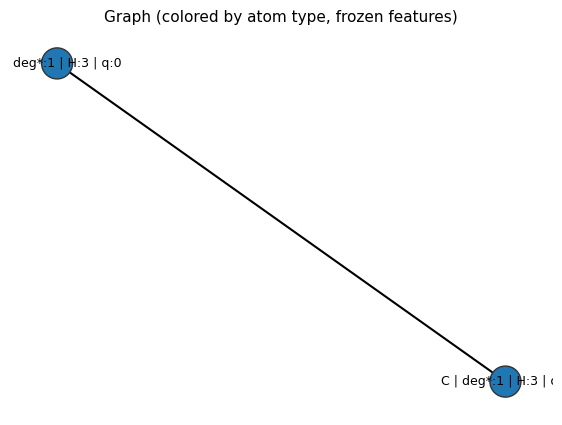

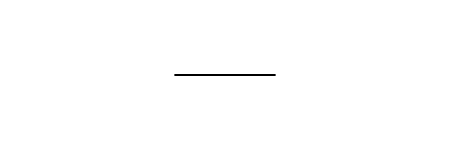

Num Nodes 2
Num Edges 1
Multiset Nodes 2
Decoding a graph with 2 nodes and 1 edges.
0
[]
No Graphs encoded ...!
[1] Original Graph


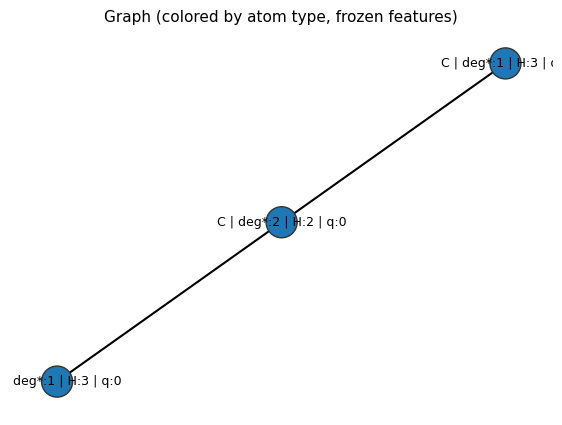

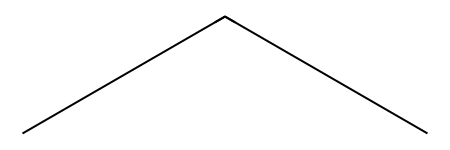

Num Nodes 3
Num Edges 2
Multiset Nodes 3
Decoding a graph with 3 nodes and 2 edges.
0
[]
No Graphs encoded ...!
[2] Original Graph


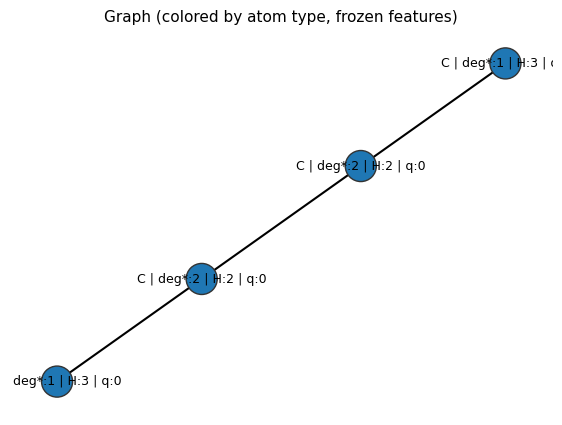

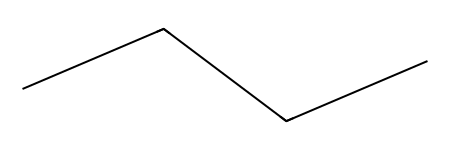

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
0
[]
No Graphs encoded ...!
[3] Original Graph


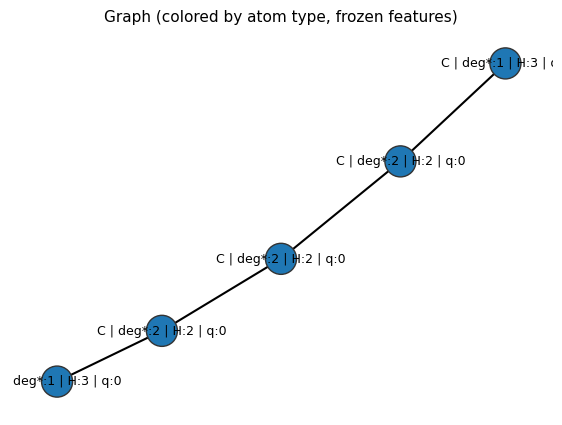

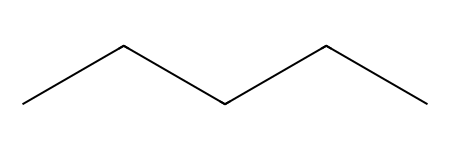

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
1
Graph Nr: 0


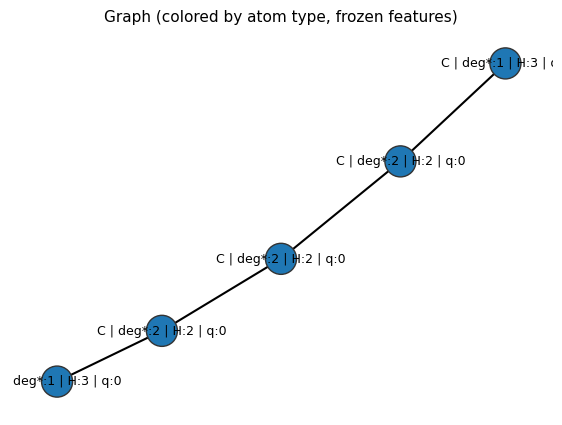

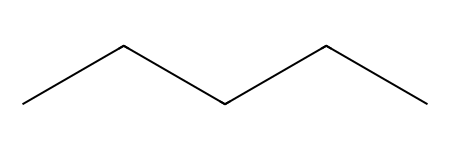

Num Atoms 5
Num Bonds 4
Is final graph:  True
[4] Original Graph


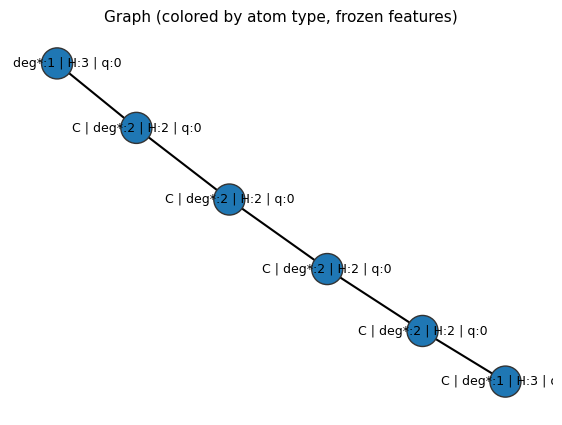

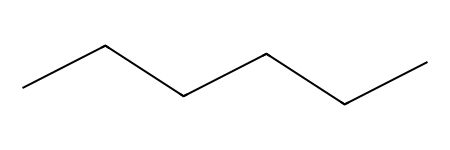

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
1
Graph Nr: 0


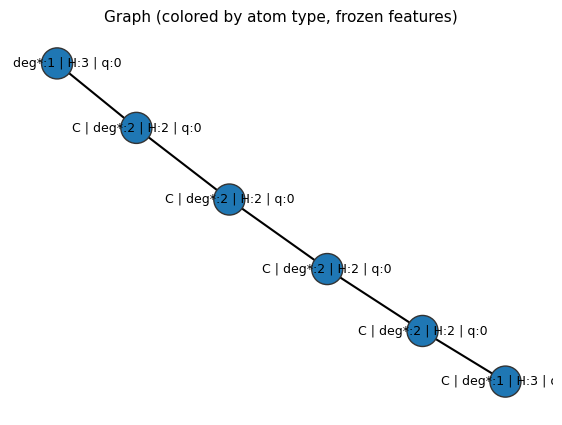

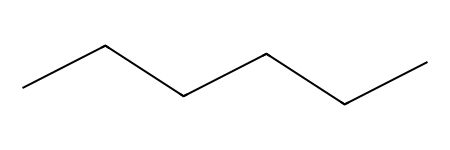

Num Atoms 6
Num Bonds 5
Is final graph:  True
[5] Original Graph


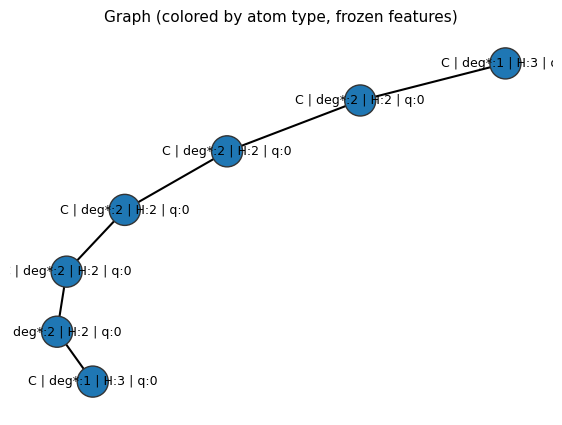

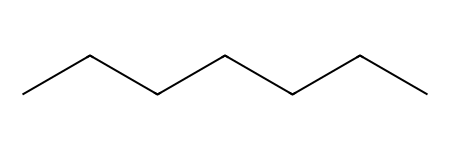

Num Nodes 7
Num Edges 6
Multiset Nodes 7
Decoding a graph with 7 nodes and 6 edges.
1
Graph Nr: 0


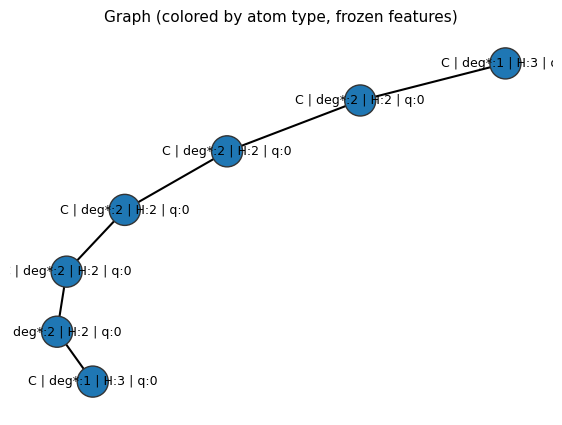

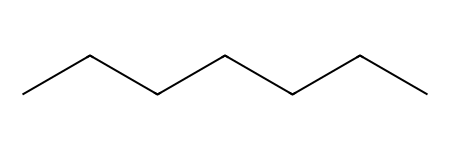

Num Atoms 7
Num Bonds 6
Is final graph:  True
[6] Original Graph


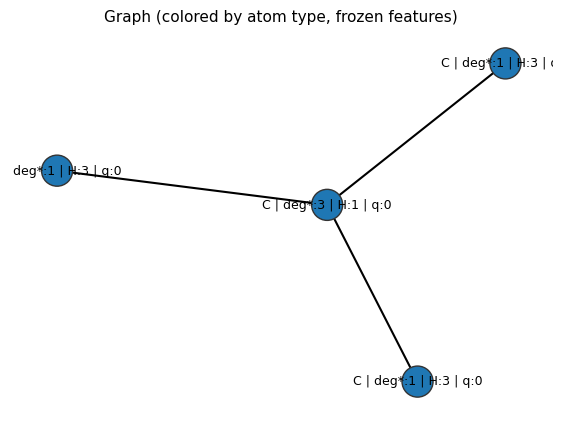

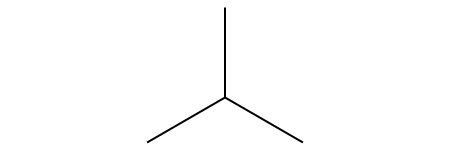

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
1
Graph Nr: 0


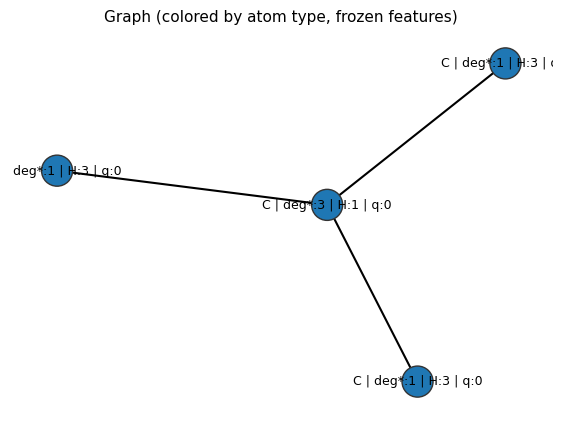

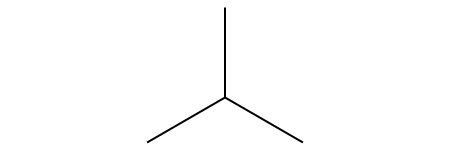

Num Atoms 4
Num Bonds 3
Is final graph:  True
[7] Original Graph


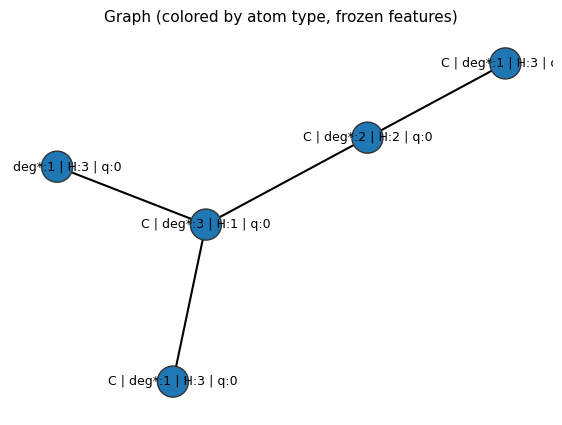

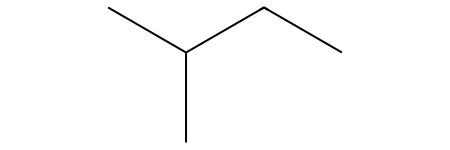

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[8] Original Graph


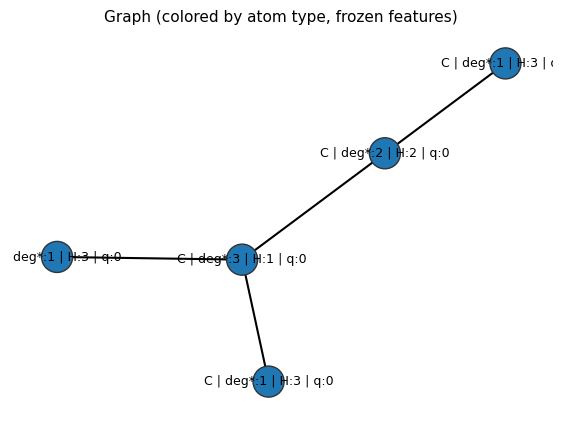

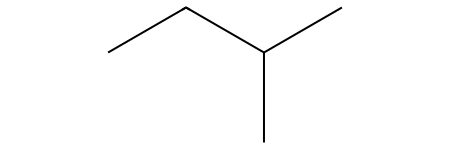

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[9] Original Graph


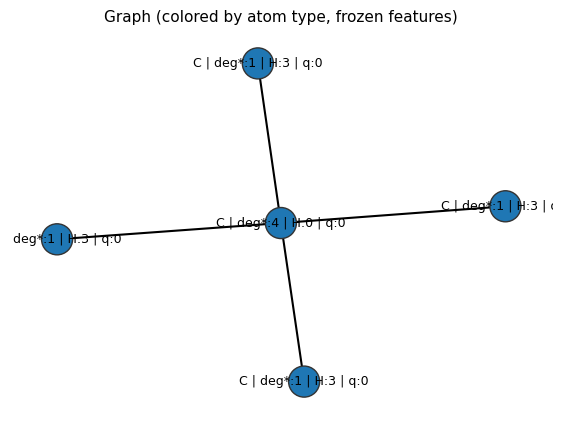

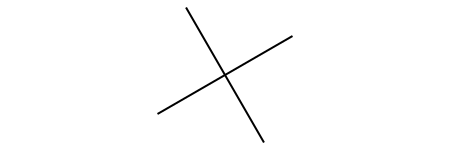

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
1
Graph Nr: 0


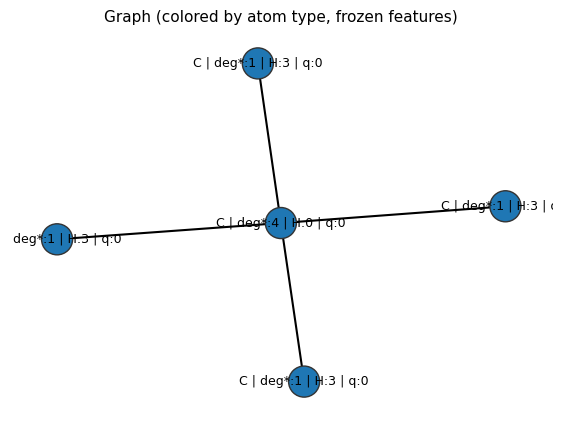

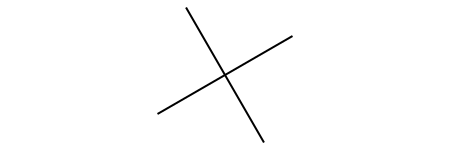

Num Atoms 5
Num Bonds 4
Is final graph:  True
[10] Original Graph


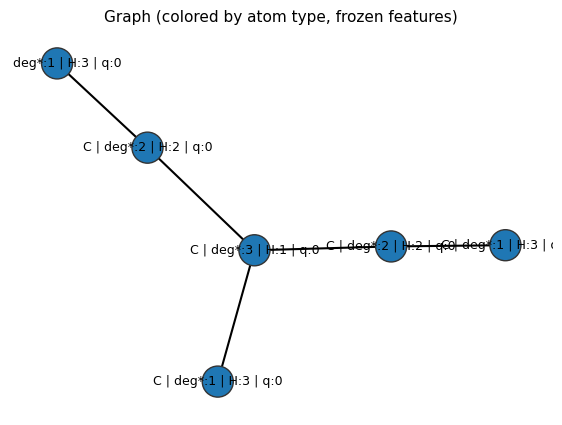

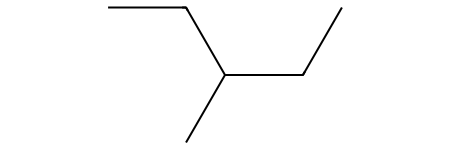

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
1
Graph Nr: 0


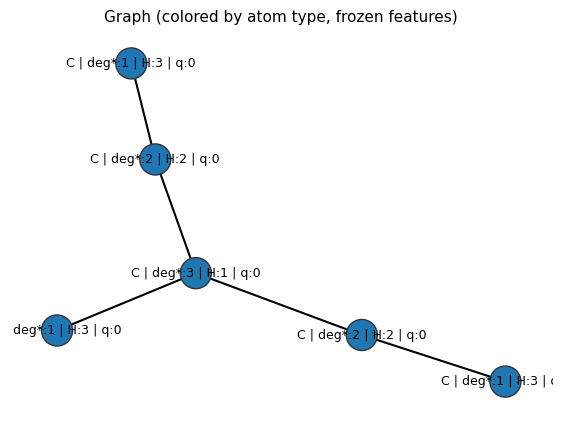

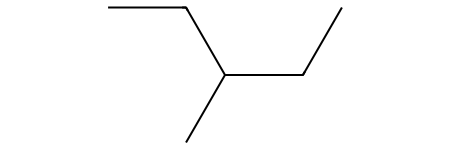

Num Atoms 6
Num Bonds 5
Is final graph:  True
[11] Original Graph


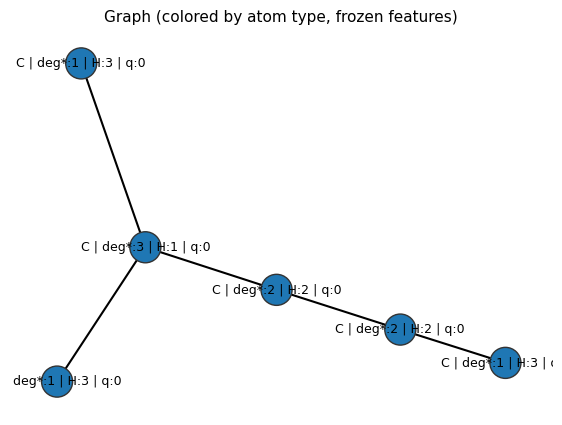

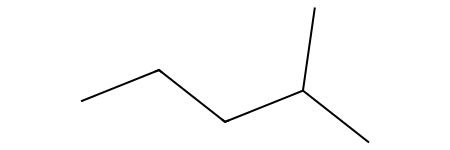

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
1
Graph Nr: 0


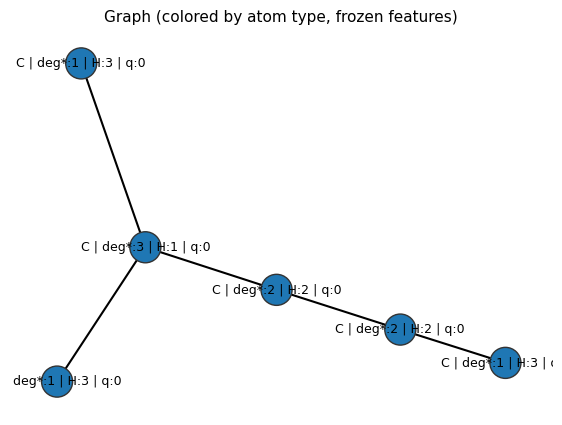

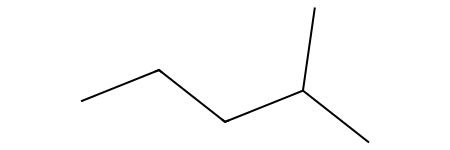

Num Atoms 6
Num Bonds 5
Is final graph:  True
[12] Original Graph


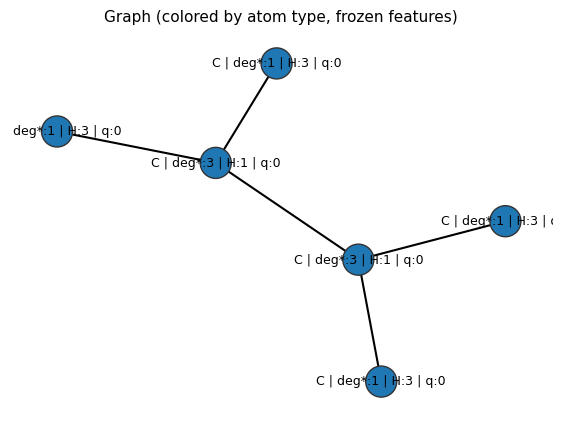

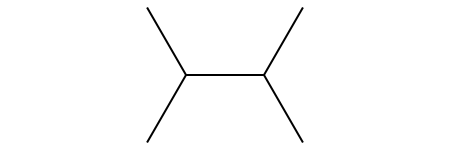

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
1
Graph Nr: 0


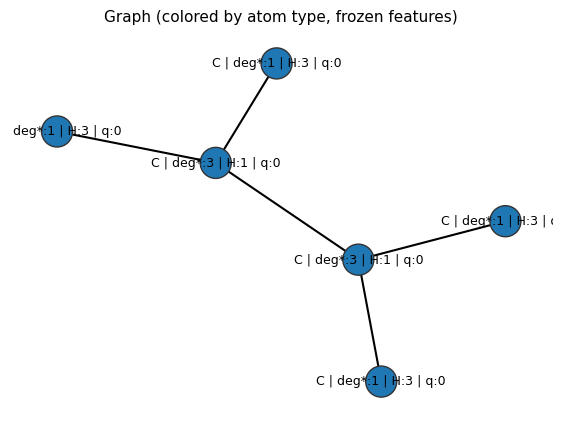

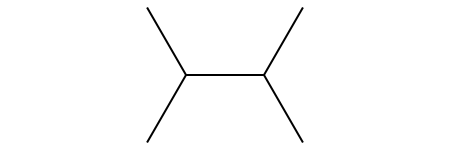

Num Atoms 6
Num Bonds 5
Is final graph:  True
[13] Original Graph


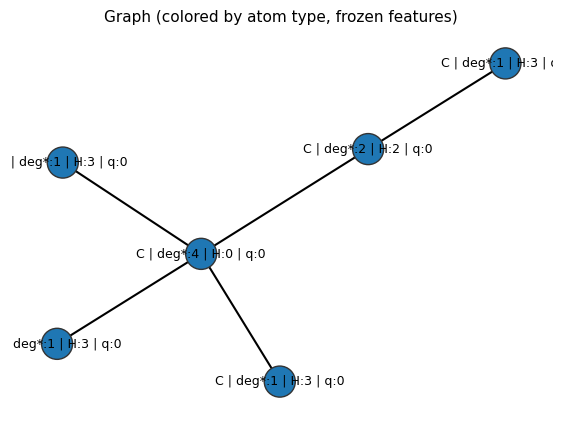

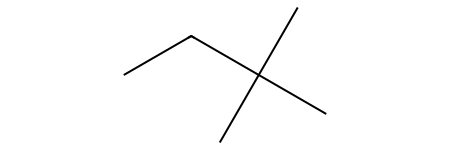

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
1
Graph Nr: 0


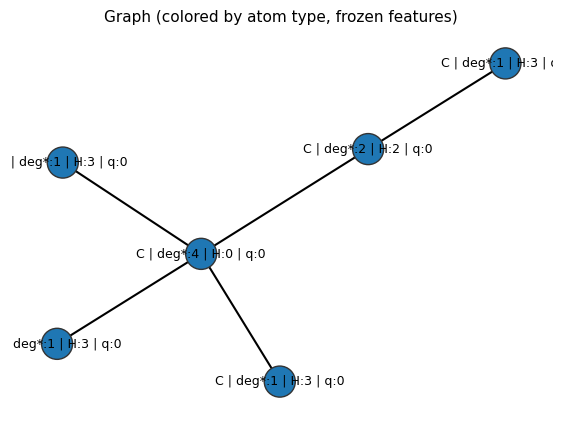

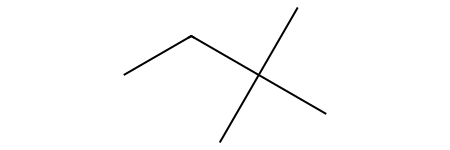

Num Atoms 6
Num Bonds 5
Is final graph:  True
[14] Original Graph


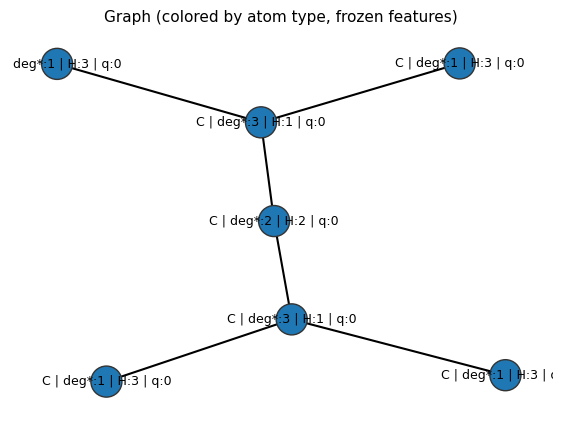

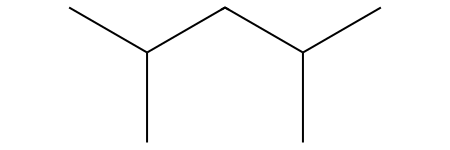

Num Nodes 7
Num Edges 6
Multiset Nodes 7
Decoding a graph with 7 nodes and 6 edges.
0
[]
No Graphs encoded ...!
[15] Original Graph


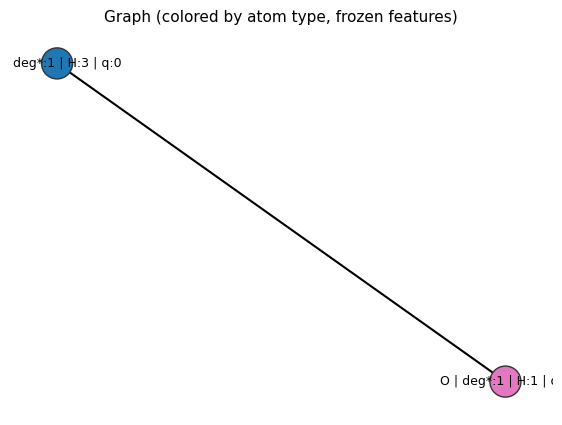

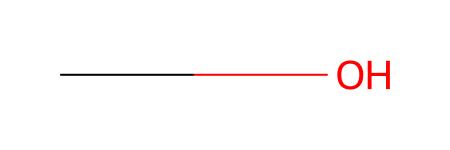

Num Nodes 2
Num Edges 1
Multiset Nodes 2
Decoding a graph with 2 nodes and 1 edges.
0
[]
No Graphs encoded ...!
[16] Original Graph


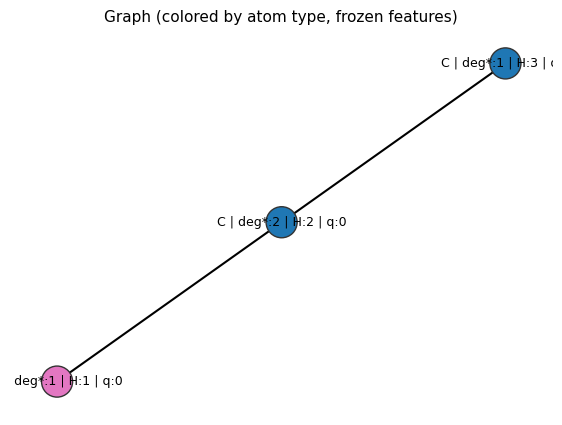

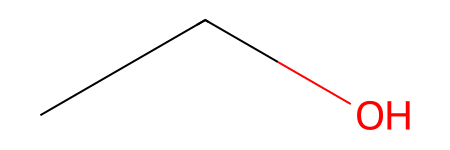

Num Nodes 3
Num Edges 2
Multiset Nodes 3
Decoding a graph with 3 nodes and 2 edges.
0
[]
No Graphs encoded ...!
[17] Original Graph


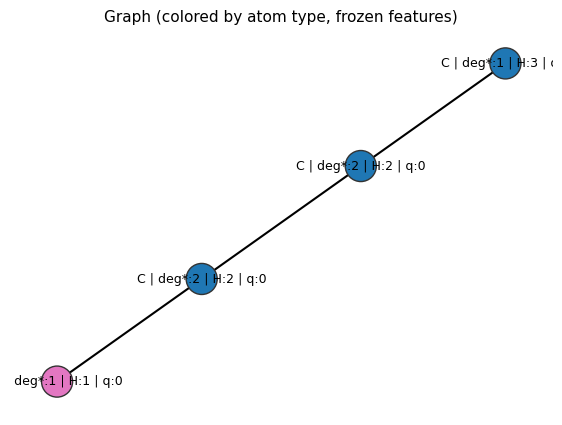

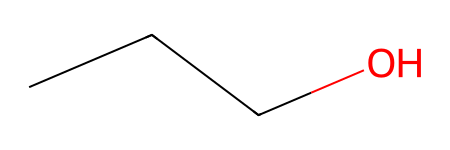

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
0
[]
No Graphs encoded ...!
[18] Original Graph


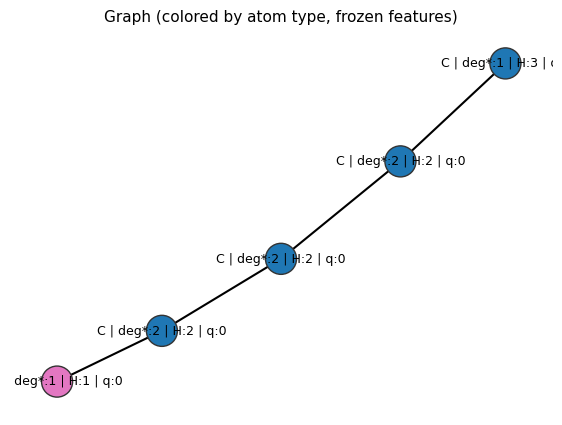

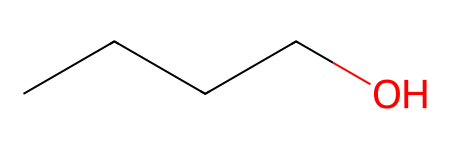

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
1
Graph Nr: 0


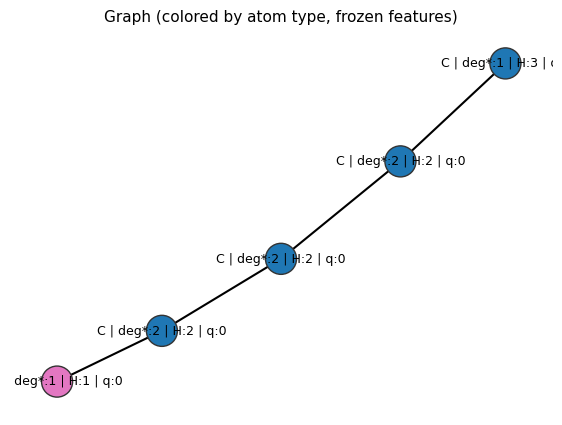

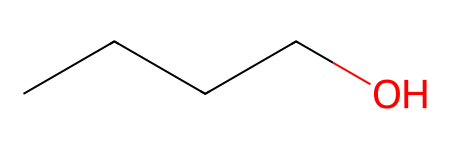

Num Atoms 5
Num Bonds 4
Is final graph:  True
[19] Original Graph


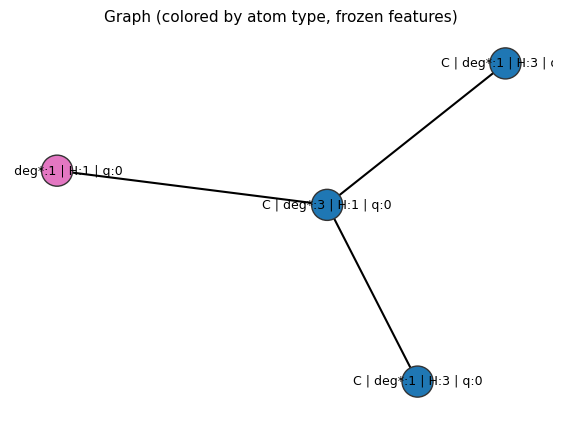

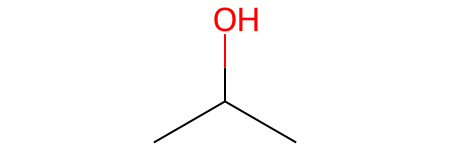

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
0
[]
No Graphs encoded ...!
[20] Original Graph


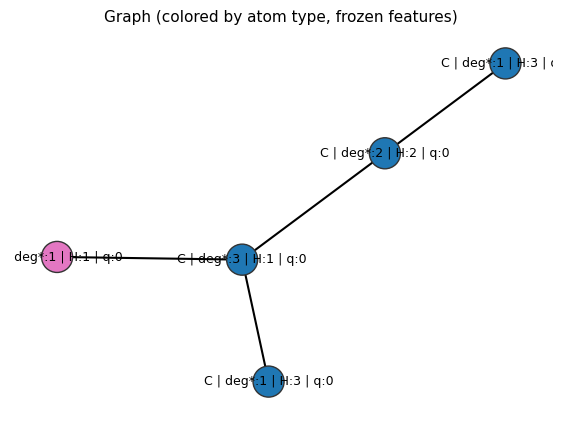

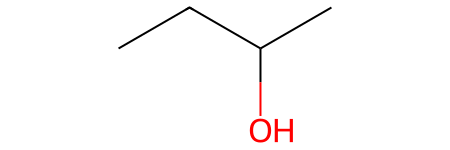

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[21] Original Graph


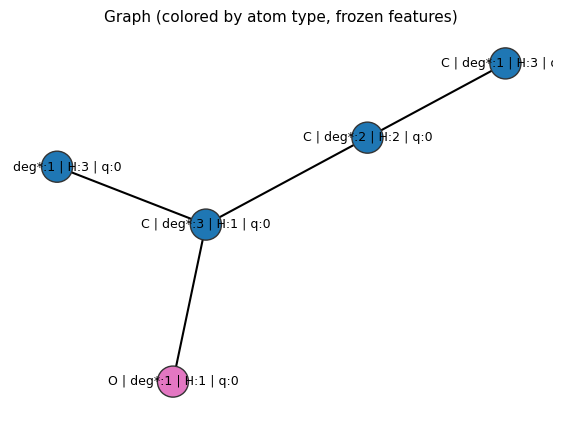

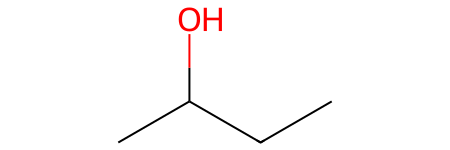

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[22] Original Graph


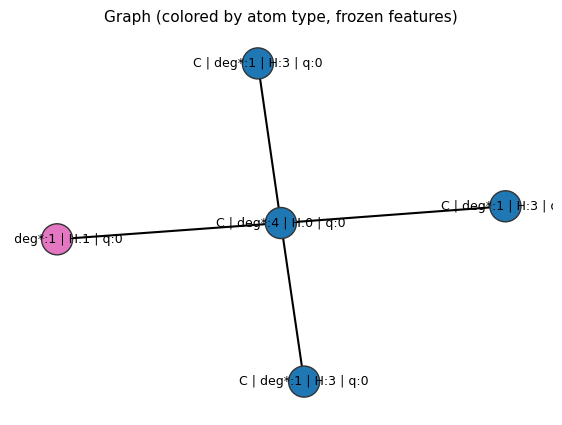

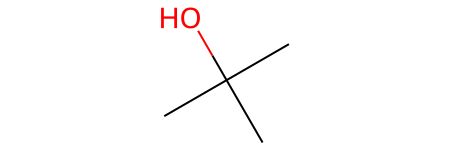

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
1
Graph Nr: 0


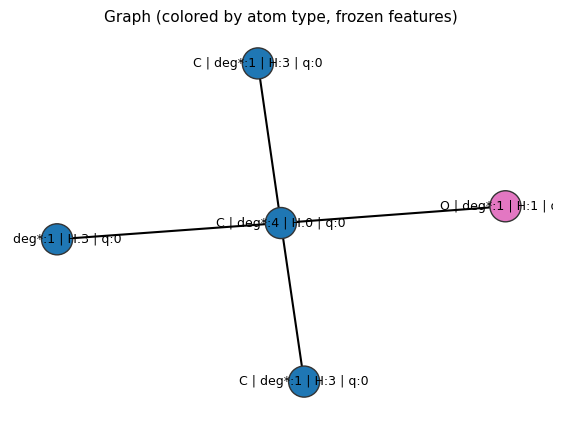

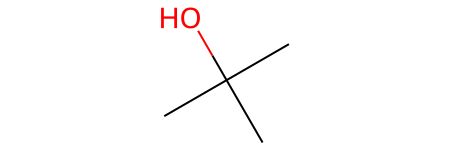

Num Atoms 5
Num Bonds 4
Is final graph:  True
[23] Original Graph


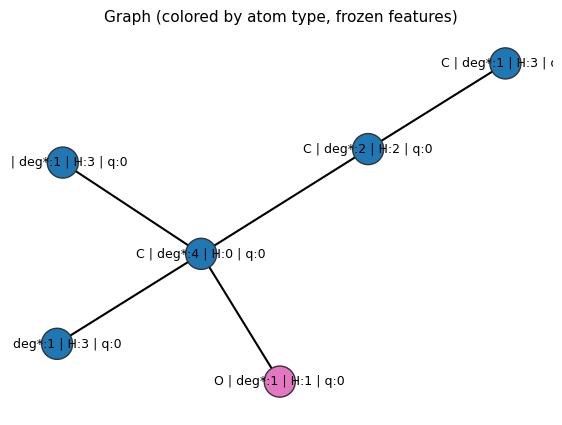

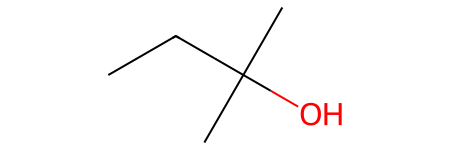

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
1
Graph Nr: 0


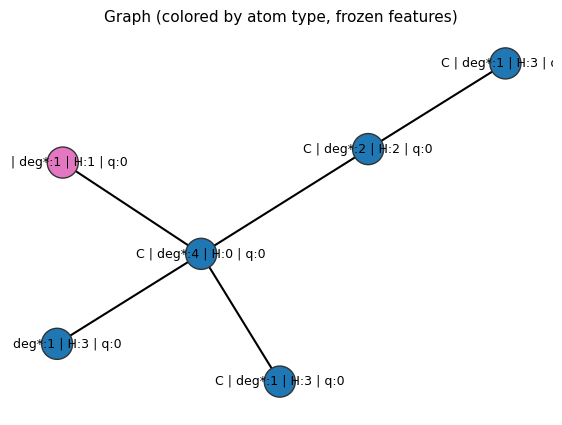

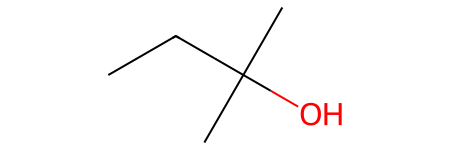

Num Atoms 6
Num Bonds 5
Is final graph:  True
[24] Original Graph


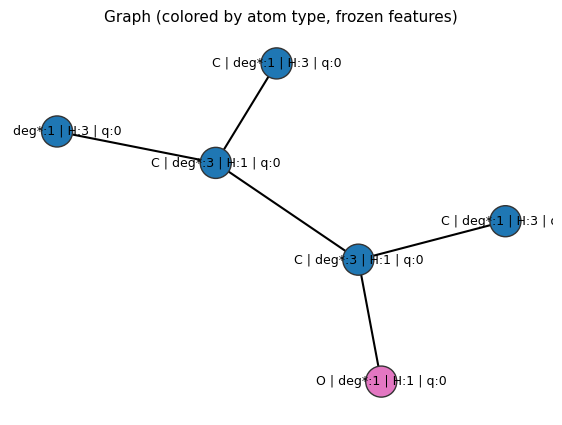

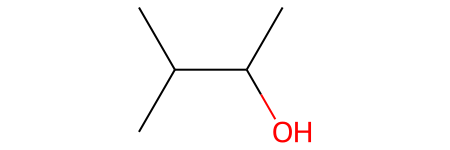

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
1
Graph Nr: 0


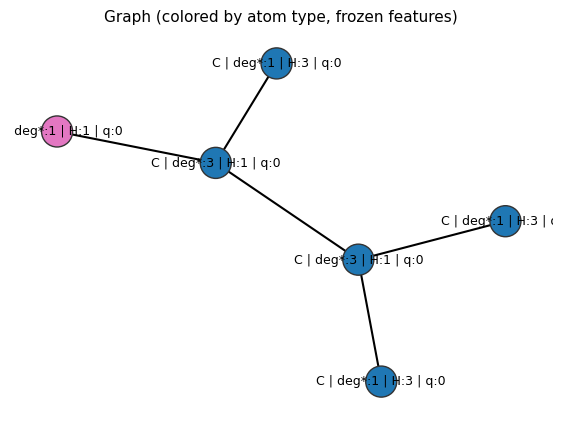

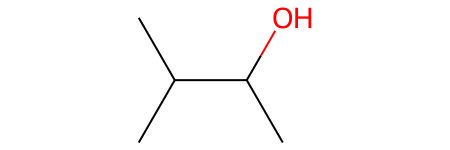

Num Atoms 6
Num Bonds 5
Is final graph:  True
[25] Original Graph


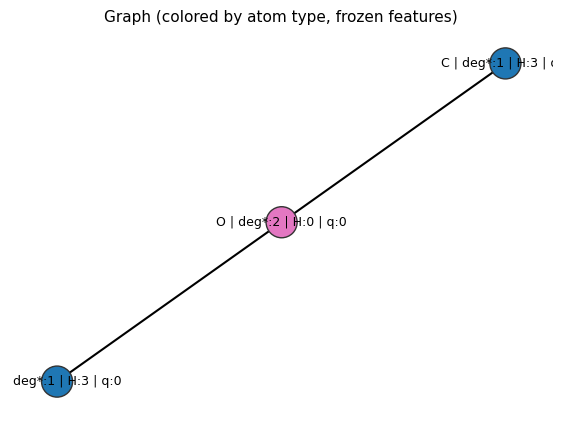

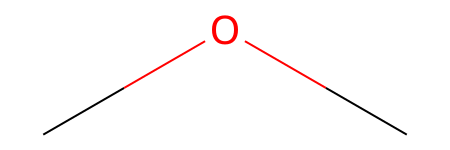

Num Nodes 3
Num Edges 2
Multiset Nodes 3
Decoding a graph with 3 nodes and 2 edges.
0
[]
No Graphs encoded ...!
[26] Original Graph


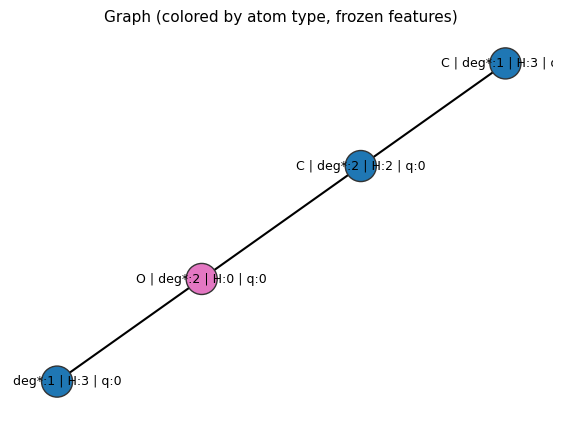

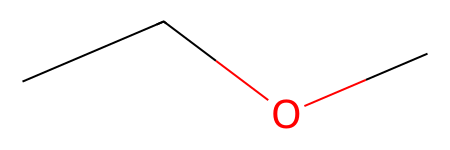

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
0
[]
No Graphs encoded ...!
[27] Original Graph


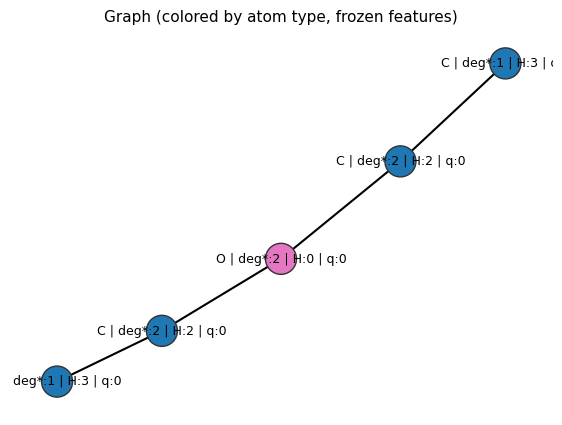

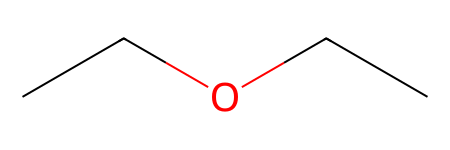

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[28] Original Graph


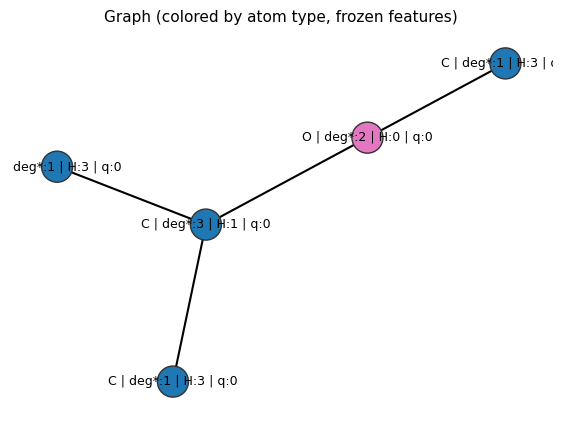

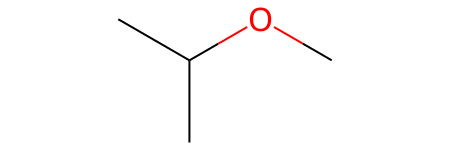

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[29] Original Graph


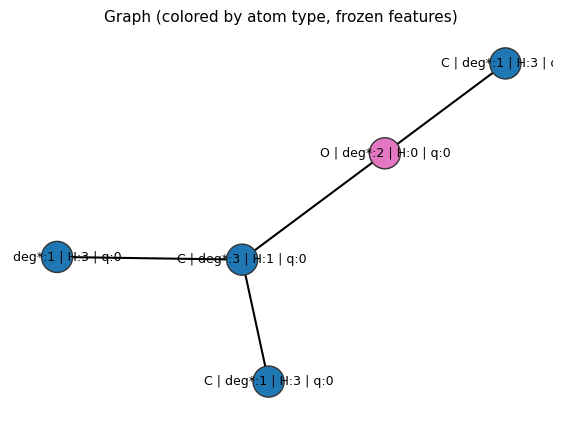

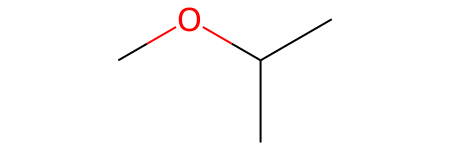

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[30] Original Graph


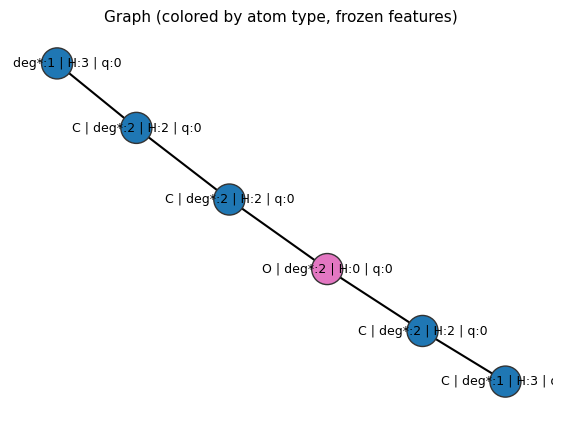

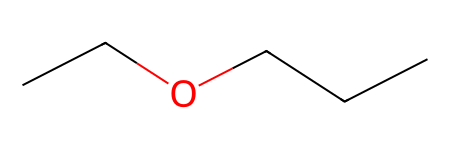

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
0
[]
No Graphs encoded ...!
[31] Original Graph


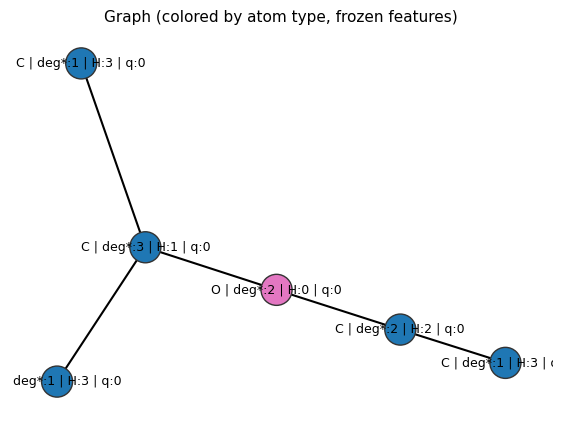

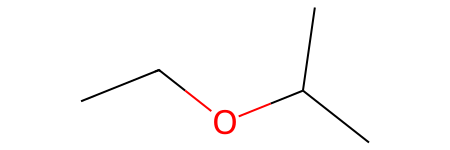

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
0
[]
No Graphs encoded ...!
[32] Original Graph


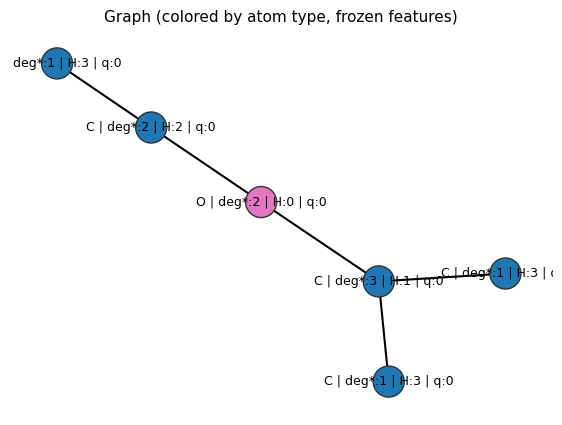

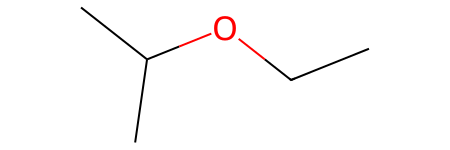

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
0
[]
No Graphs encoded ...!
[33] Original Graph


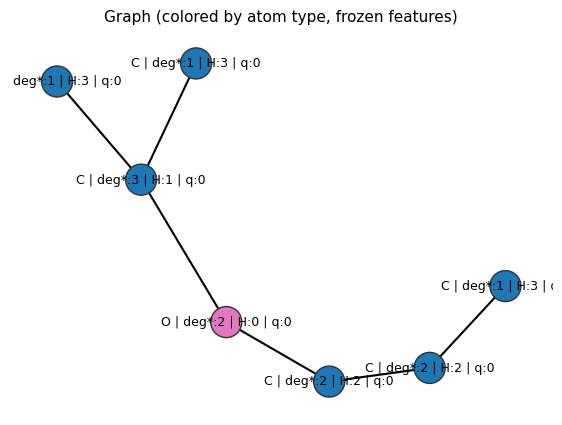

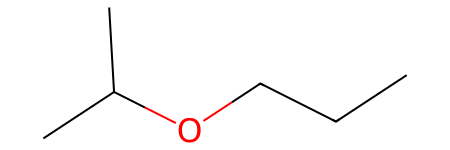

Num Nodes 7
Num Edges 6
Multiset Nodes 7
Decoding a graph with 7 nodes and 6 edges.
0
[]
No Graphs encoded ...!
[34] Original Graph


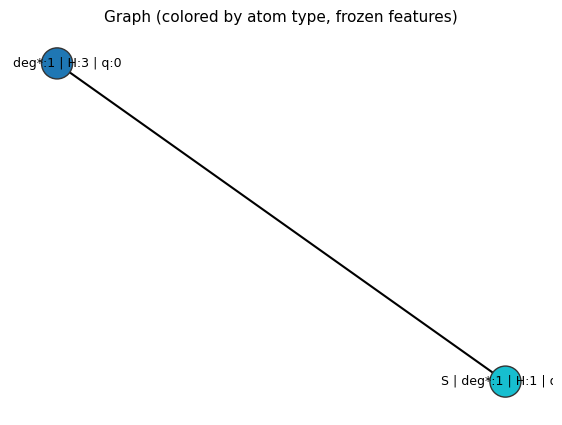

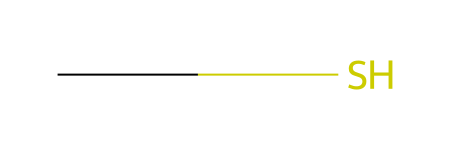

Num Nodes 2
Num Edges 1
Multiset Nodes 2
Decoding a graph with 2 nodes and 1 edges.
0
[]
No Graphs encoded ...!
[35] Original Graph


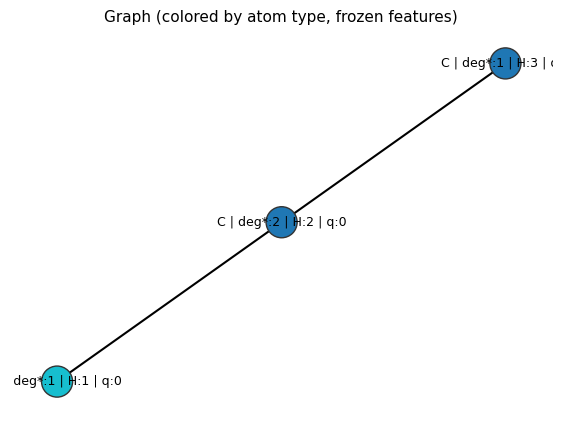

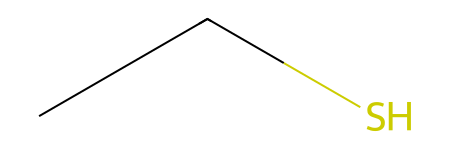

Num Nodes 3
Num Edges 2
Multiset Nodes 3
Decoding a graph with 3 nodes and 2 edges.
0
[]
No Graphs encoded ...!
[36] Original Graph


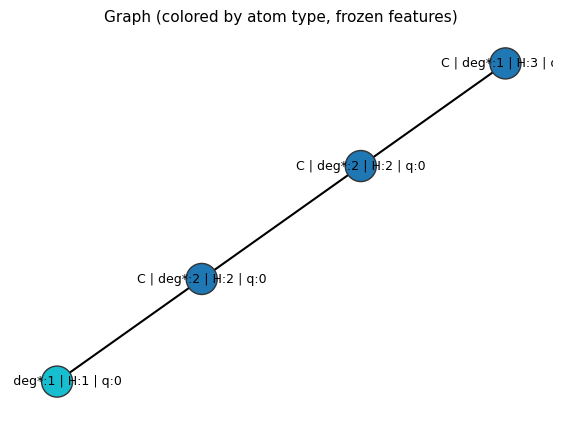

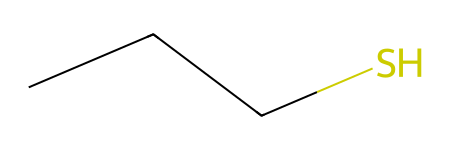

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
0
[]
No Graphs encoded ...!
[37] Original Graph


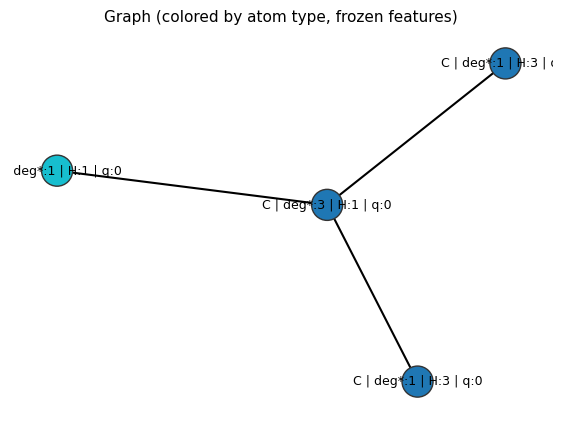

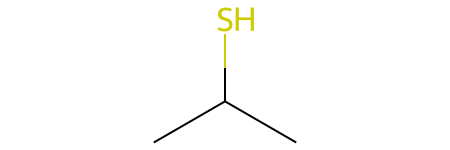

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
0
[]
No Graphs encoded ...!
[38] Original Graph


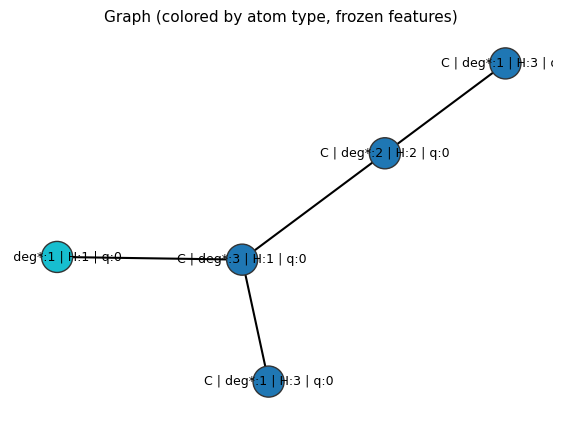

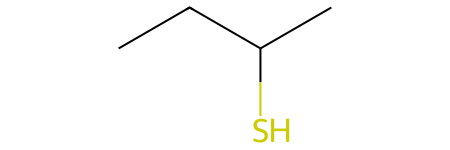

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[39] Original Graph


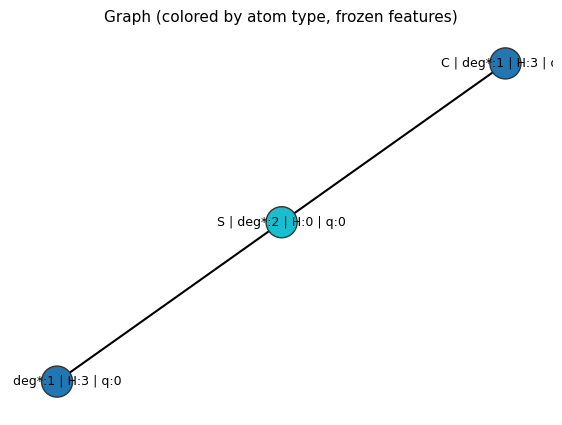

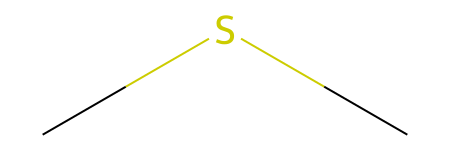

Num Nodes 3
Num Edges 2
Multiset Nodes 3
Decoding a graph with 3 nodes and 2 edges.
0
[]
No Graphs encoded ...!
[40] Original Graph


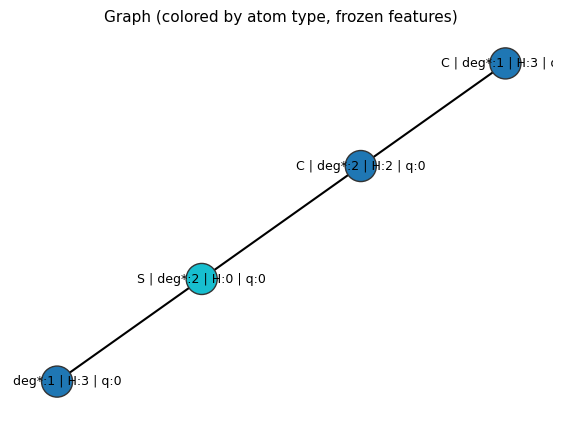

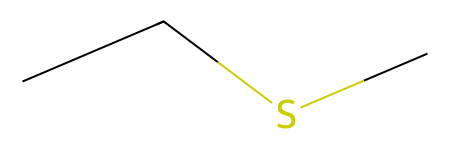

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
0
[]
No Graphs encoded ...!
[41] Original Graph


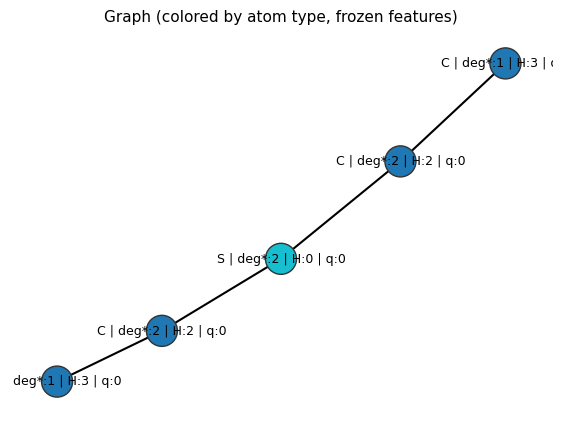

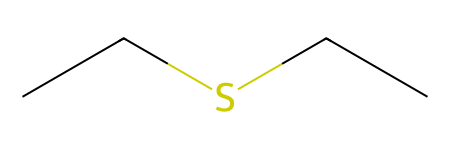

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[42] Original Graph


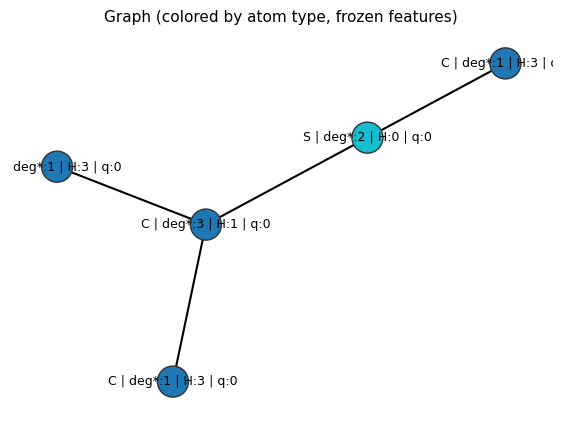

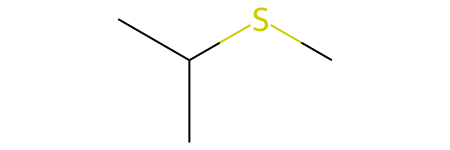

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[43] Original Graph


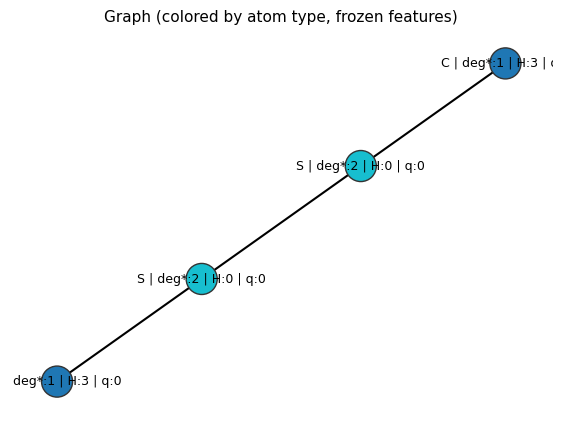

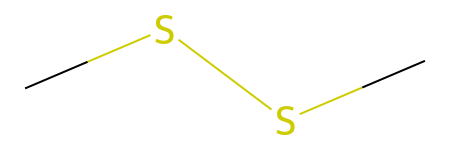

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
1
Graph Nr: 0


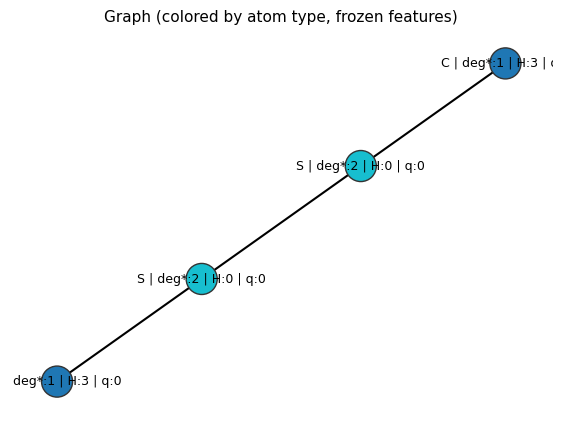

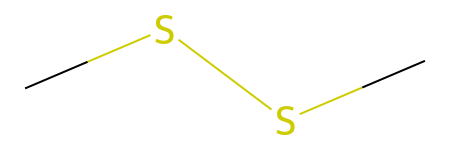

Num Atoms 4
Num Bonds 3
Is final graph:  True
[44] Original Graph


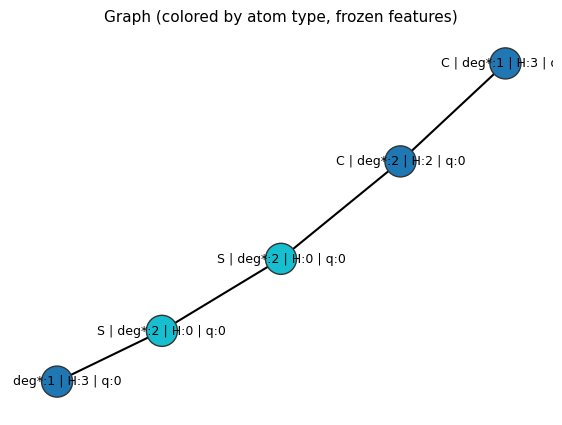

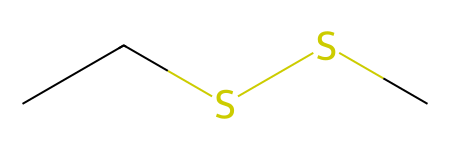

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[45] Original Graph


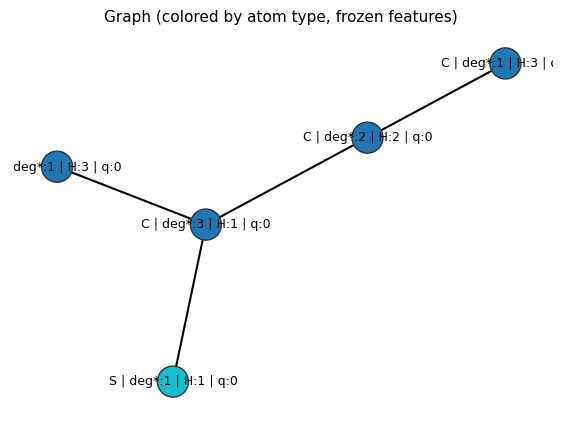

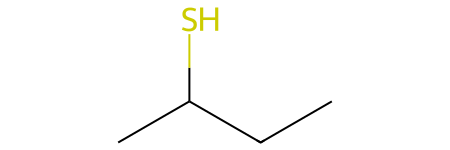

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[46] Original Graph


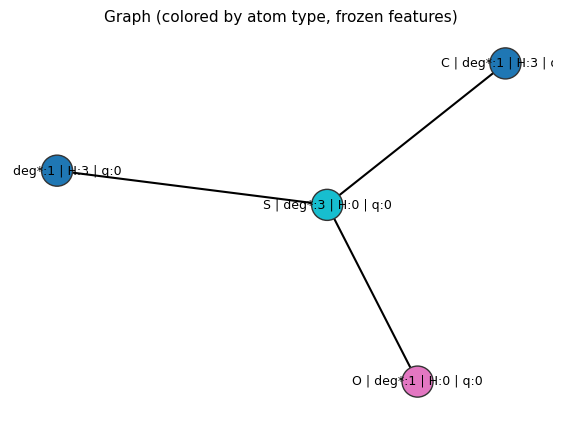

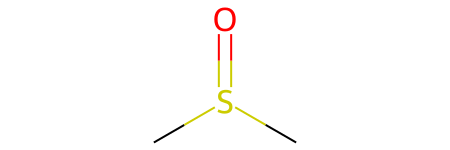

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
0
[]
No Graphs encoded ...!
[47] Original Graph


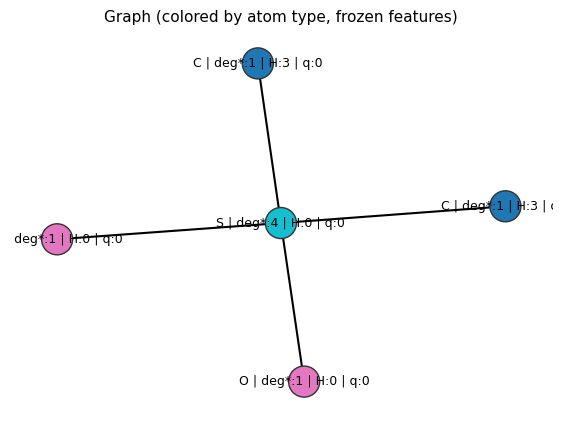

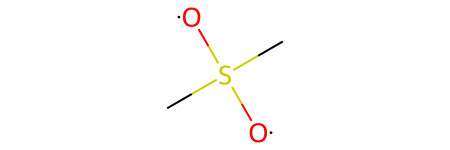

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[48] Original Graph


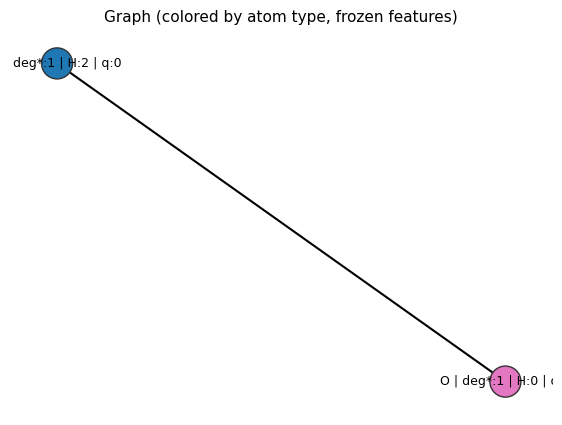

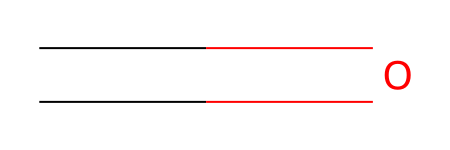

Num Nodes 2
Num Edges 1
Multiset Nodes 2
Decoding a graph with 2 nodes and 1 edges.
0
[]
No Graphs encoded ...!
[49] Original Graph


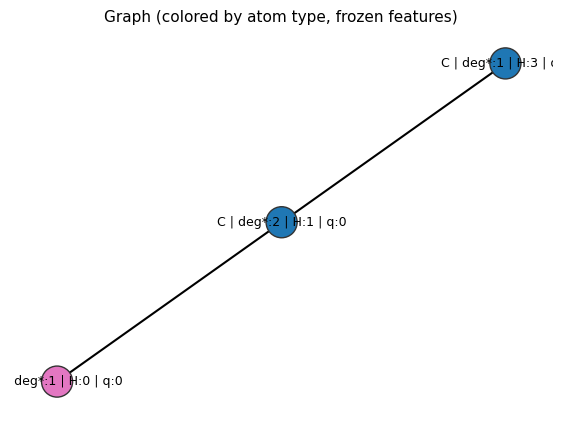

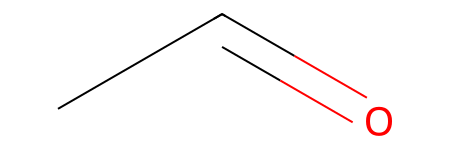

Num Nodes 3
Num Edges 2
Multiset Nodes 3
Decoding a graph with 3 nodes and 2 edges.
0
[]
No Graphs encoded ...!
[50] Original Graph


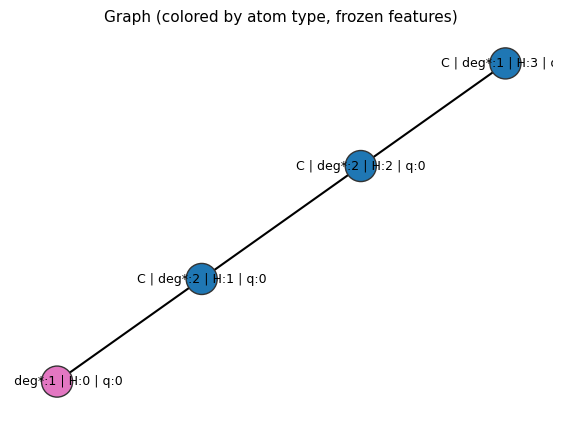

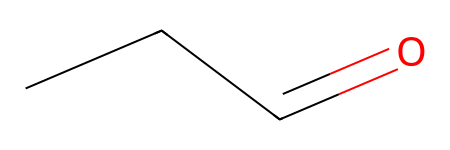

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
0
[]
No Graphs encoded ...!
[51] Original Graph


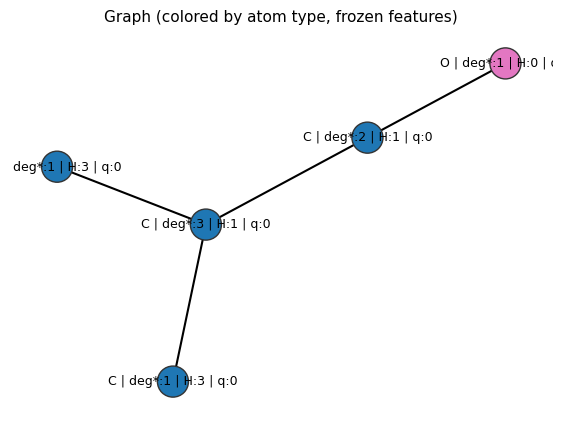

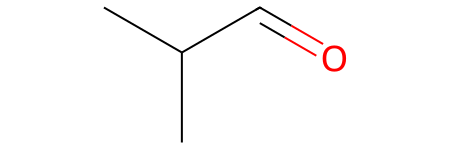

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[52] Original Graph


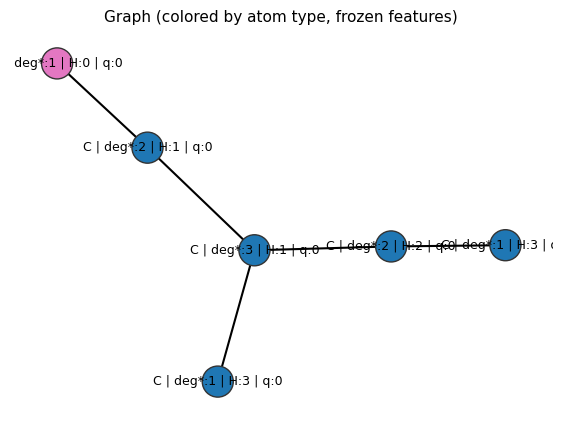

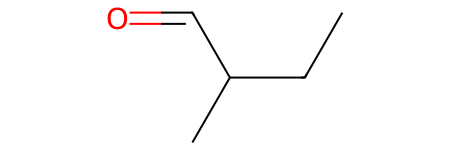

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
0
[]
No Graphs encoded ...!
[53] Original Graph


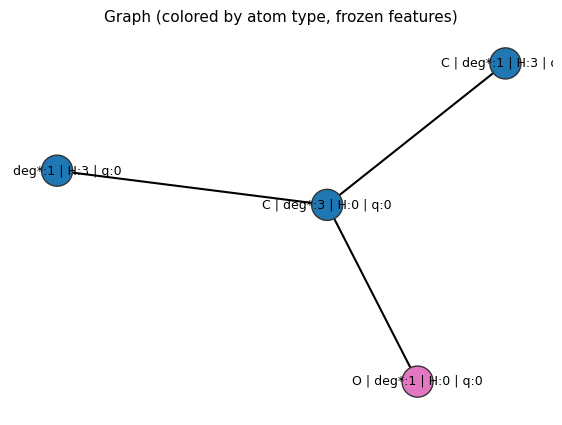

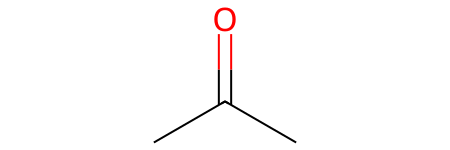

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
0
[]
No Graphs encoded ...!
[54] Original Graph


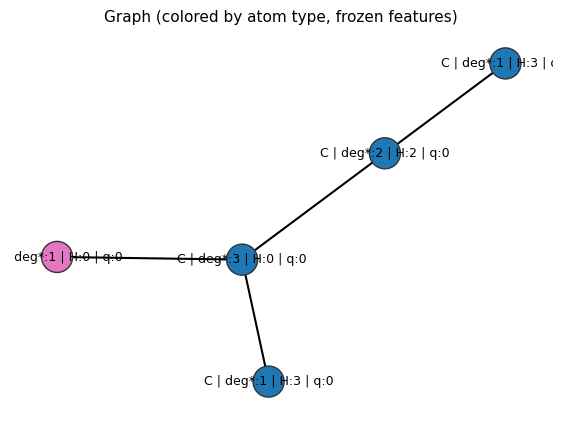

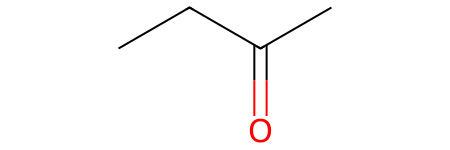

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[55] Original Graph


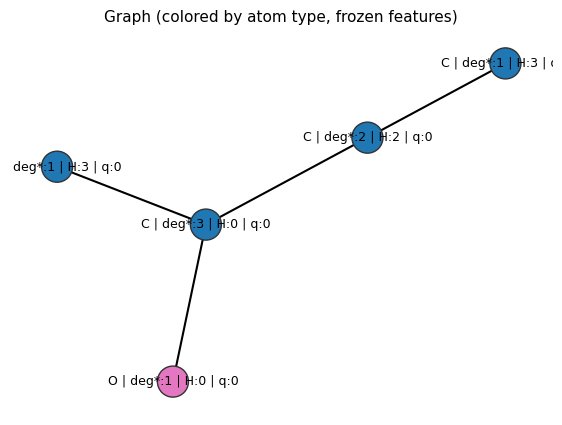

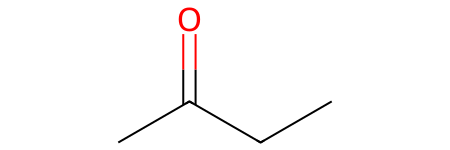

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[56] Original Graph


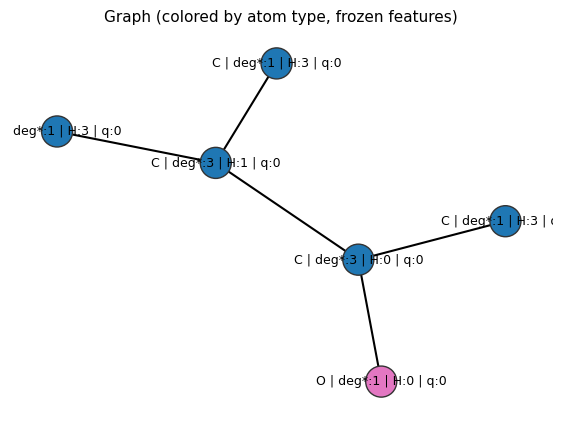

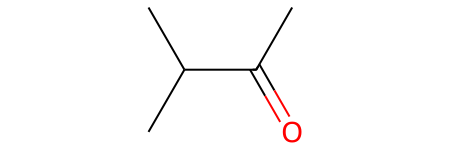

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
0
[]
No Graphs encoded ...!
[57] Original Graph


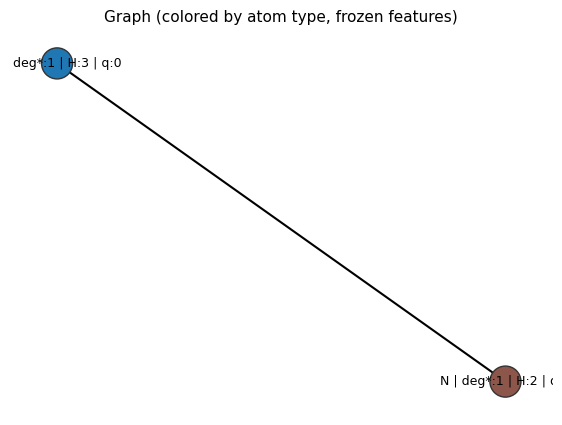

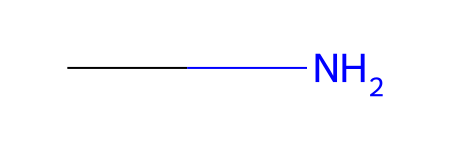

Num Nodes 2
Num Edges 1
Multiset Nodes 2
Decoding a graph with 2 nodes and 1 edges.
0
[]
No Graphs encoded ...!
[58] Original Graph


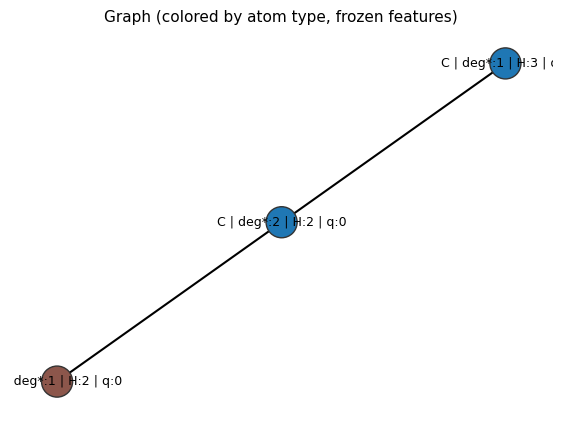

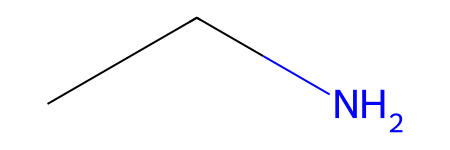

Num Nodes 3
Num Edges 2
Multiset Nodes 3
Decoding a graph with 3 nodes and 2 edges.
0
[]
No Graphs encoded ...!
[59] Original Graph


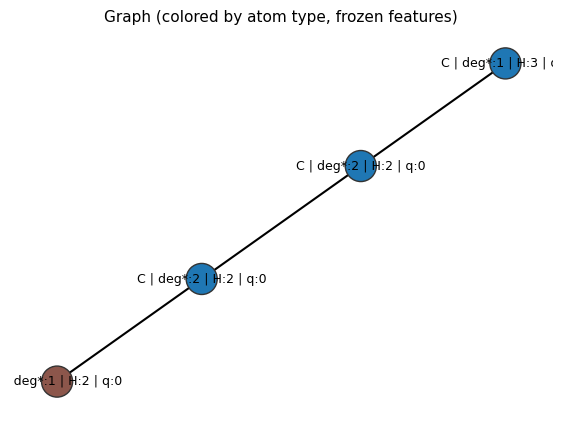

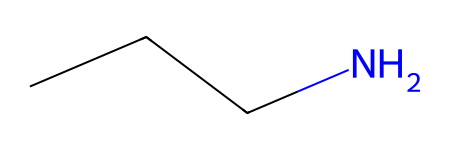

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
0
[]
No Graphs encoded ...!
[60] Original Graph


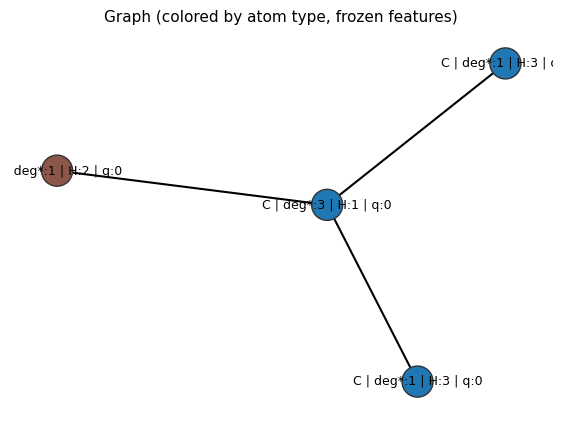

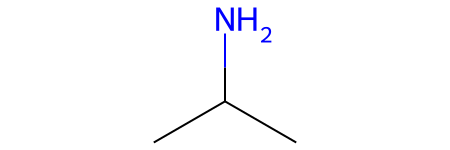

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
0
[]
No Graphs encoded ...!
[61] Original Graph


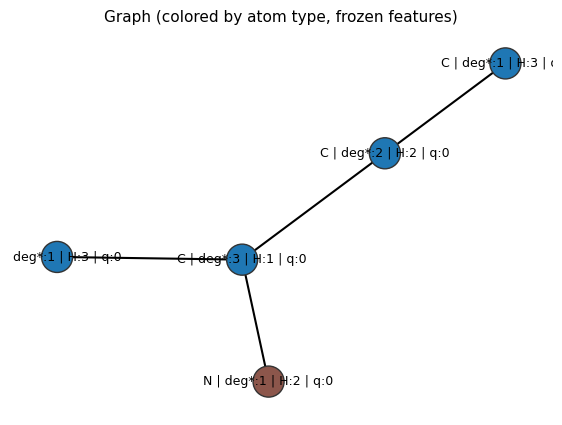

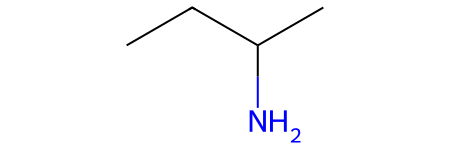

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[62] Original Graph


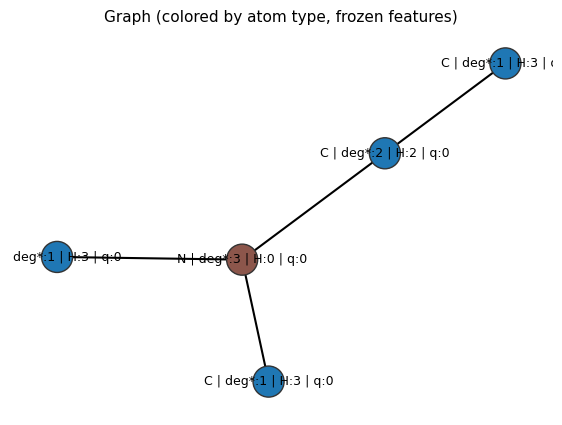

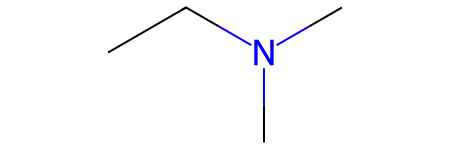

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[63] Original Graph


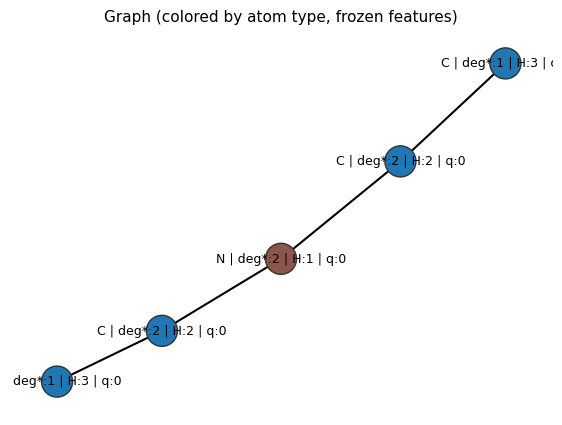

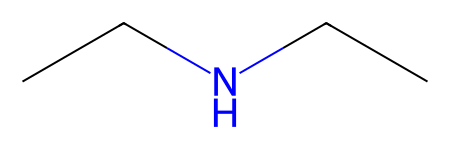

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[64] Original Graph


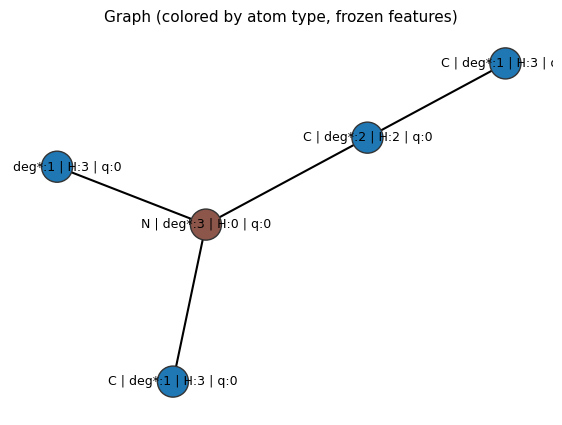

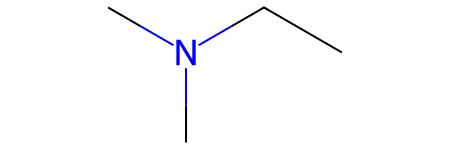

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[65] Original Graph


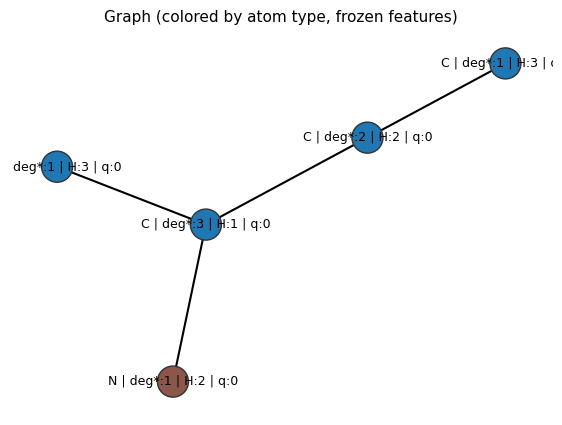

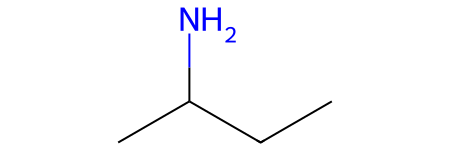

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[66] Original Graph


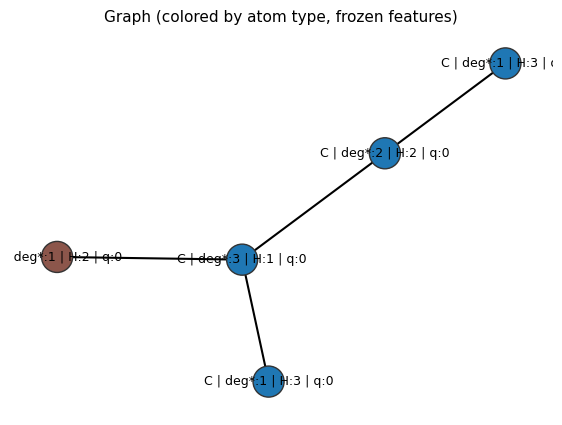

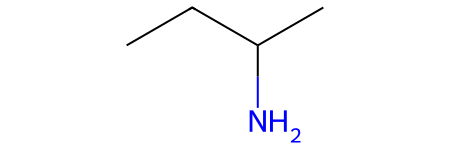

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[67] Original Graph


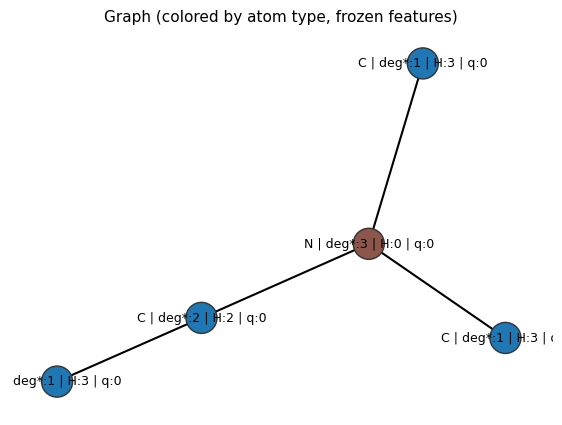

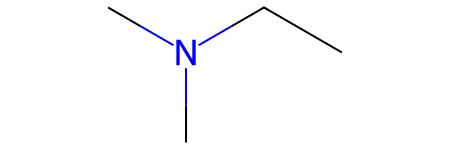

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[68] Original Graph


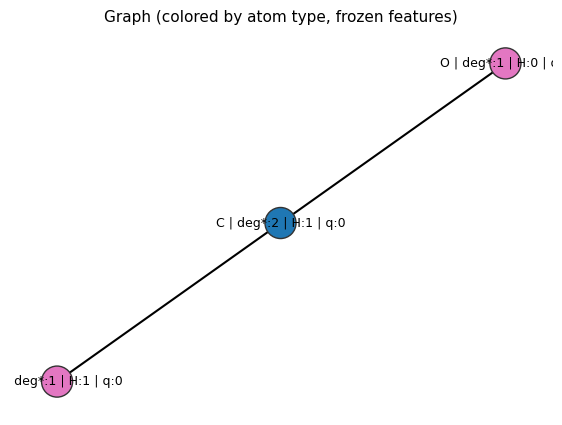

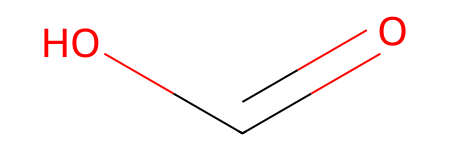

Num Nodes 3
Num Edges 2
Multiset Nodes 3
Decoding a graph with 3 nodes and 2 edges.
0
[]
No Graphs encoded ...!
[69] Original Graph


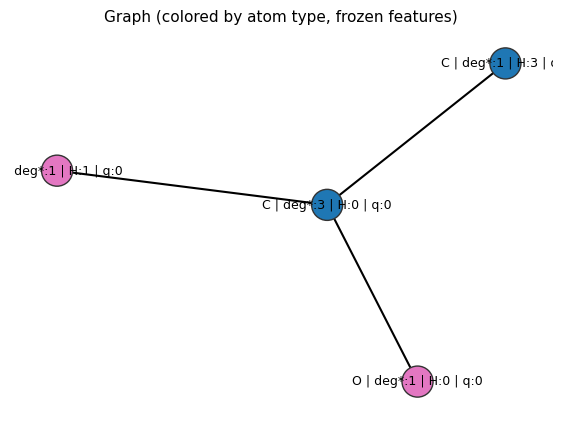

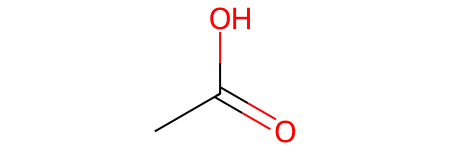

Num Nodes 4
Num Edges 3
Multiset Nodes 4
Decoding a graph with 4 nodes and 3 edges.
0
[]
No Graphs encoded ...!
[70] Original Graph


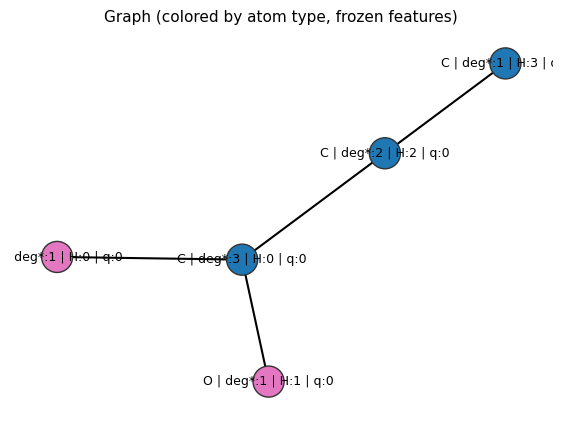

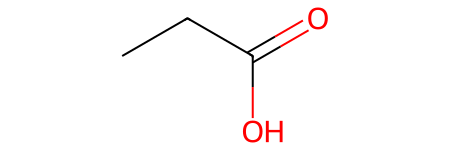

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[71] Original Graph


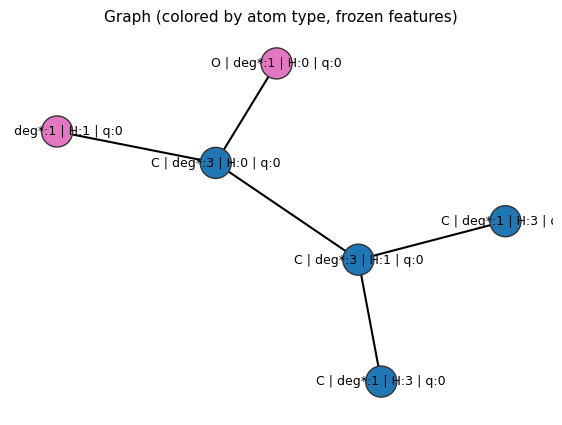

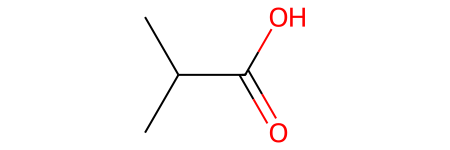

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
0
[]
No Graphs encoded ...!
[72] Original Graph


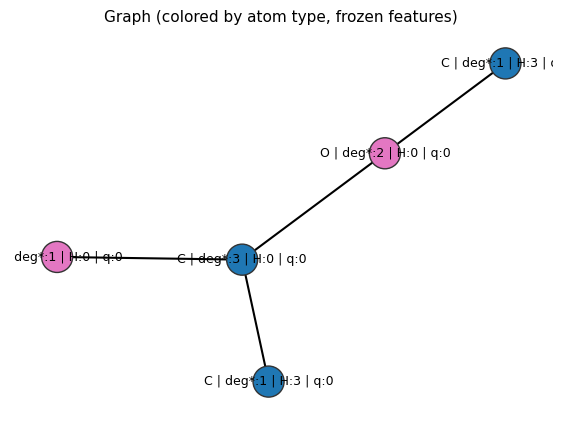

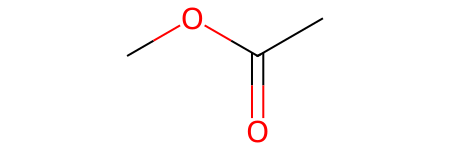

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[73] Original Graph


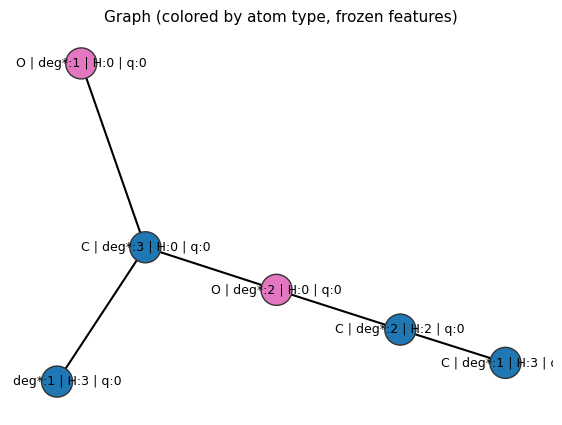

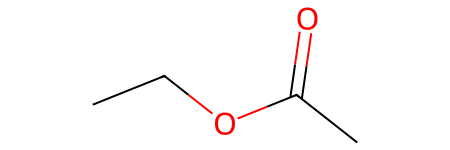

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
0
[]
No Graphs encoded ...!
[74] Original Graph


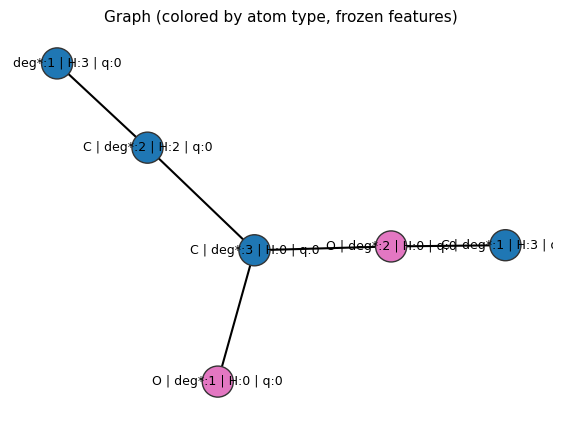

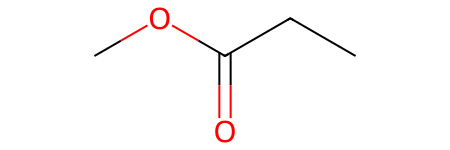

Num Nodes 6
Num Edges 5
Multiset Nodes 6
Decoding a graph with 6 nodes and 5 edges.
0
[]
No Graphs encoded ...!
[75] Original Graph


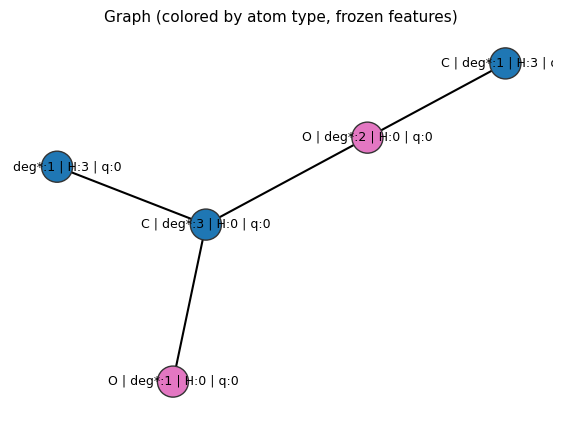

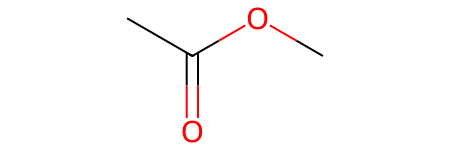

Num Nodes 5
Num Edges 4
Multiset Nodes 5
Decoding a graph with 5 nodes and 4 edges.
0
[]
No Graphs encoded ...!
[76] Original Graph


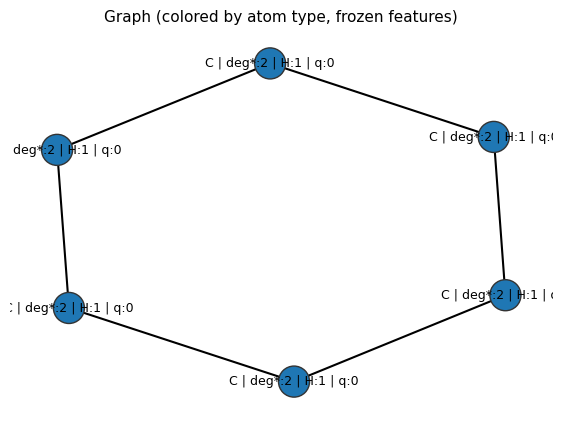

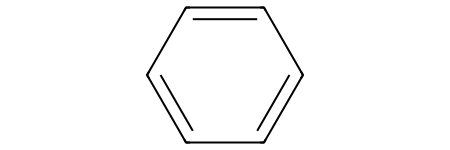

Num Nodes 6
Num Edges 6
Multiset Nodes 6
Decoding a graph with 6 nodes and 6 edges.
0
[]
No Graphs encoded ...!
[77] Original Graph


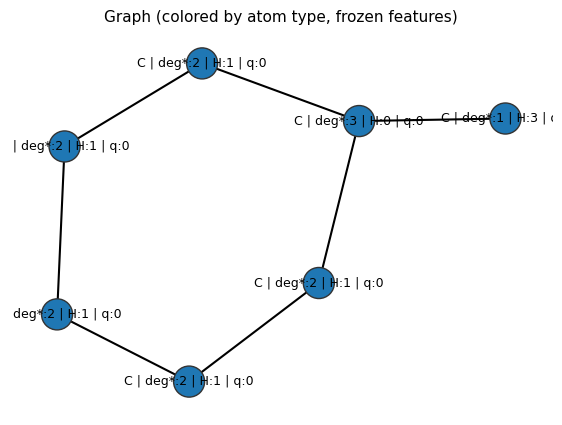

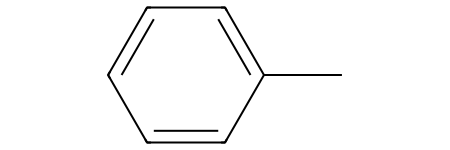

Num Nodes 7
Num Edges 7
Multiset Nodes 7
Decoding a graph with 7 nodes and 7 edges.
1
Graph Nr: 0


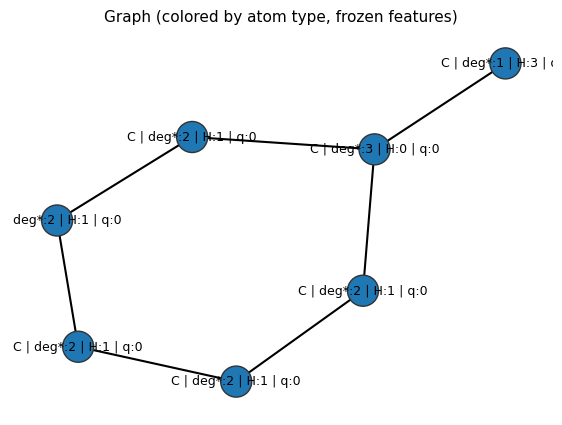

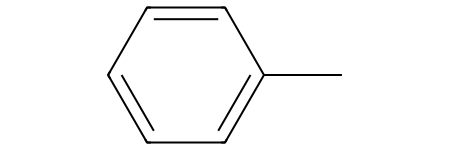

Num Atoms 7
Num Bonds 7
Is final graph:  True
[78] Original Graph


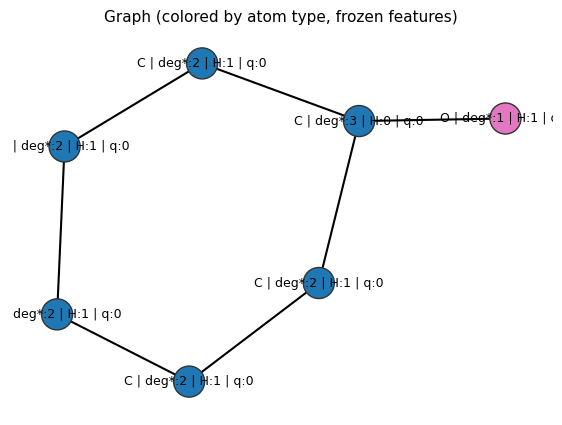

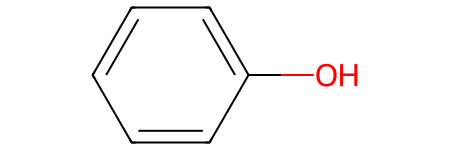

Num Nodes 7
Num Edges 7
Multiset Nodes 7
Decoding a graph with 7 nodes and 7 edges.
1
Graph Nr: 0


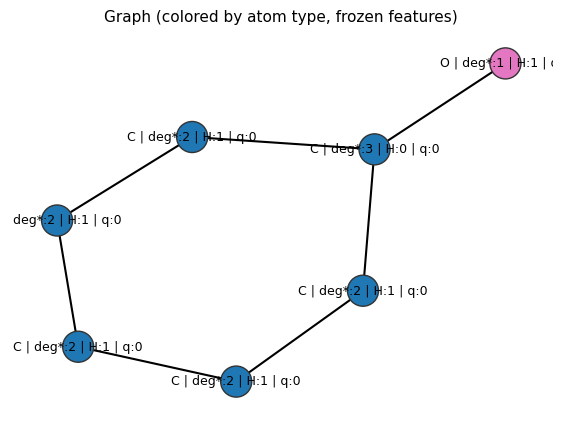

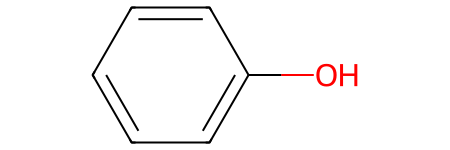

Num Atoms 7
Num Bonds 7
Is final graph:  True
[79] Original Graph


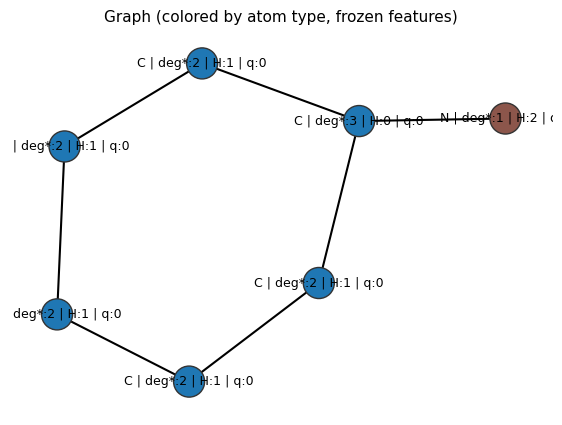

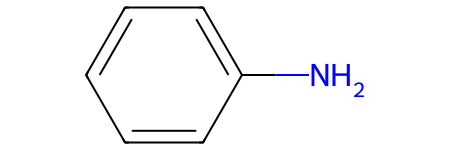

Num Nodes 7
Num Edges 7
Multiset Nodes 7
Decoding a graph with 7 nodes and 7 edges.
1
Graph Nr: 0


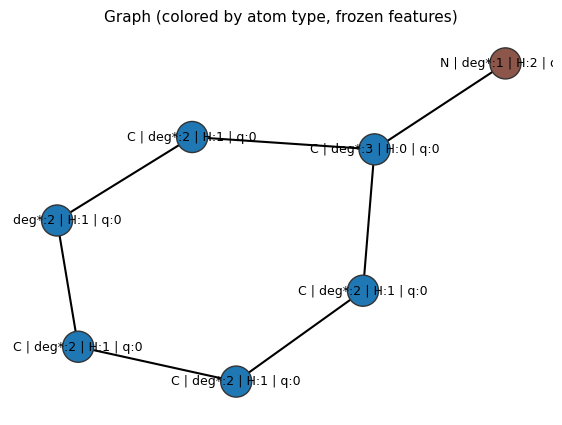

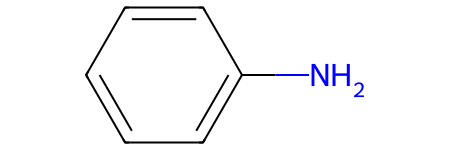

Num Atoms 7
Num Bonds 7
Is final graph:  True
[80] Original Graph


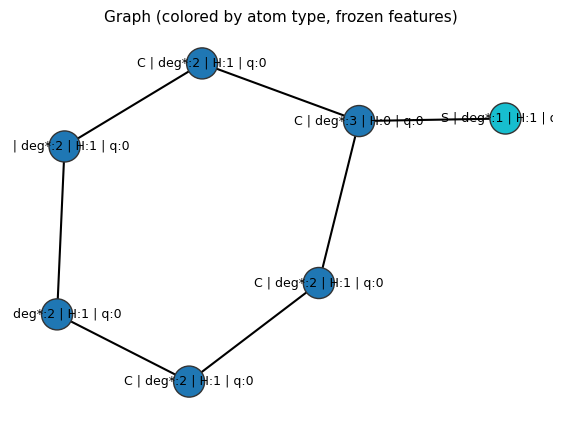

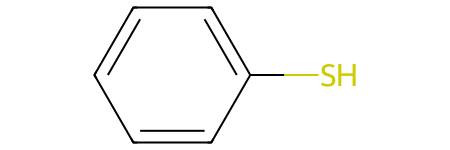

Num Nodes 7
Num Edges 7
Multiset Nodes 7
Decoding a graph with 7 nodes and 7 edges.
1
Graph Nr: 0


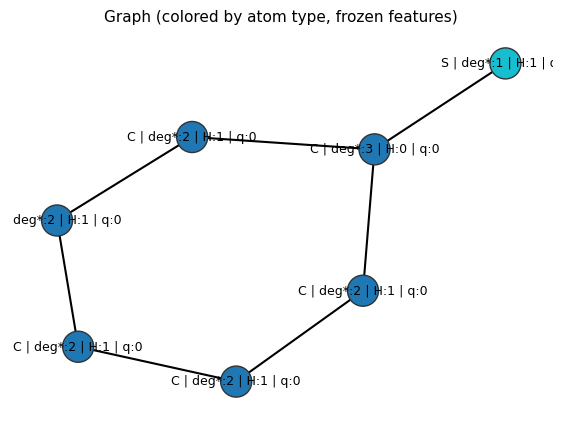

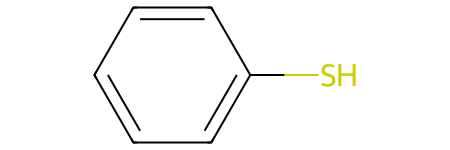

Num Atoms 7
Num Bonds 7
Is final graph:  True
[81] Original Graph


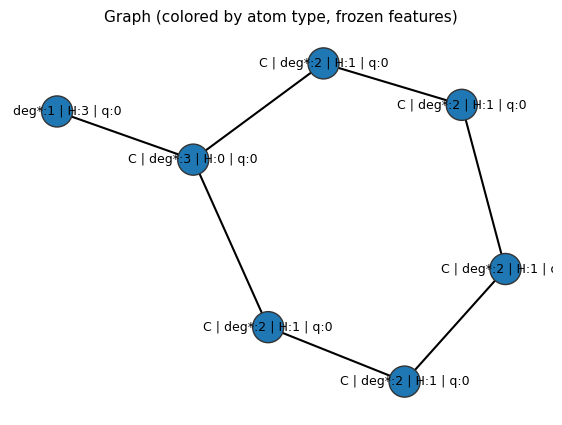

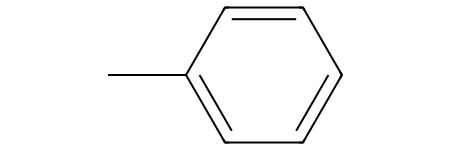

Num Nodes 7
Num Edges 7
Multiset Nodes 7
Decoding a graph with 7 nodes and 7 edges.
1
Graph Nr: 0


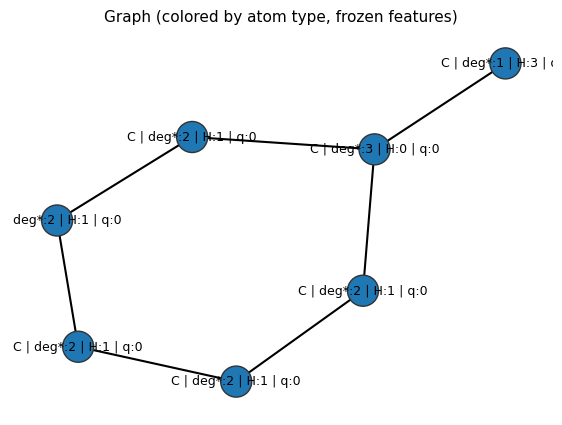

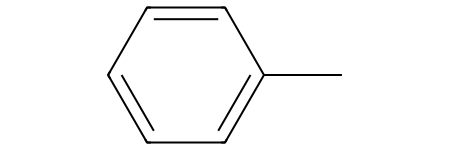

Num Atoms 7
Num Bonds 7
Is final graph:  True
[82] Original Graph


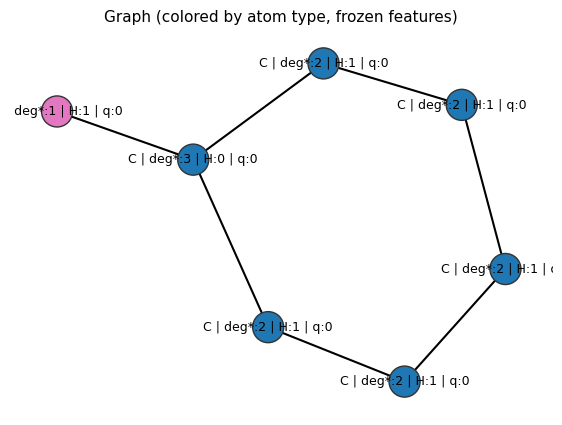

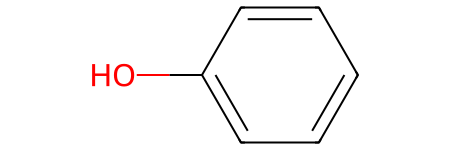

Num Nodes 7
Num Edges 7
Multiset Nodes 7
Decoding a graph with 7 nodes and 7 edges.
1
Graph Nr: 0


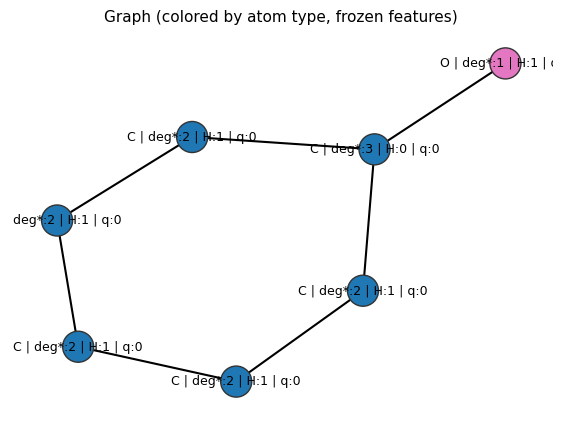

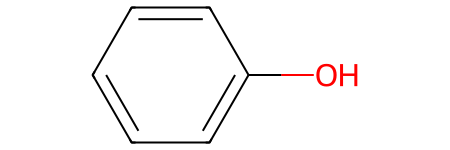

Num Atoms 7
Num Bonds 7
Is final graph:  True
[83] Original Graph


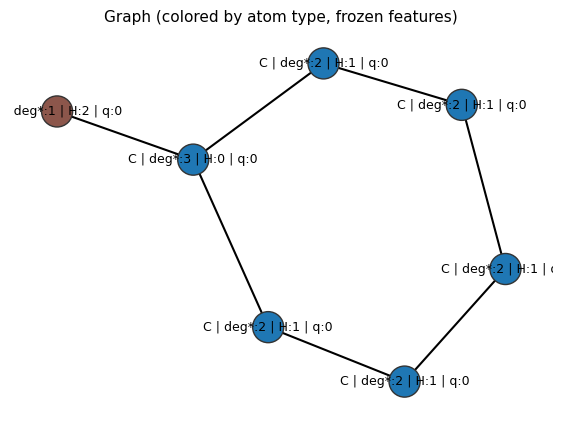

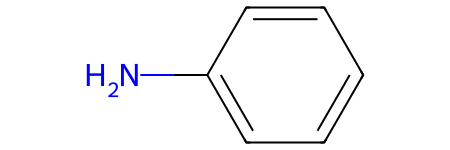

Num Nodes 7
Num Edges 7
Multiset Nodes 7
Decoding a graph with 7 nodes and 7 edges.
1
Graph Nr: 0


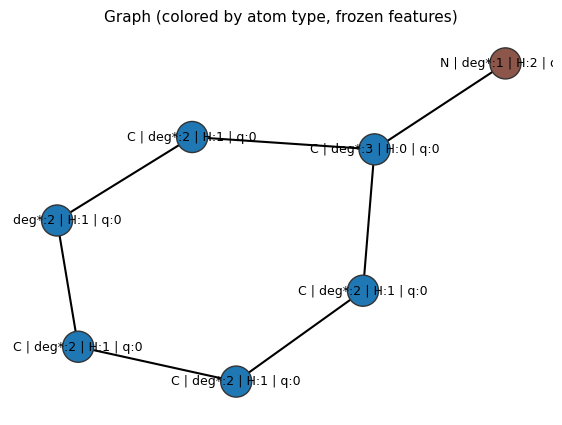

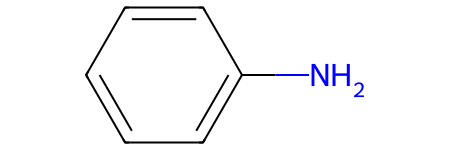

Num Atoms 7
Num Bonds 7
Is final graph:  True
[84] Original Graph


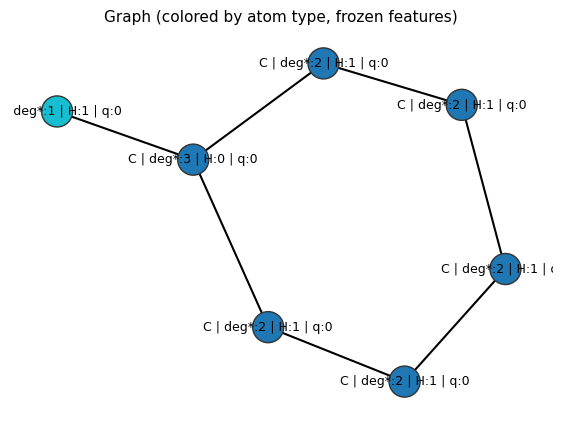

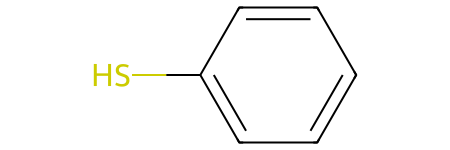

Num Nodes 7
Num Edges 7
Multiset Nodes 7
Decoding a graph with 7 nodes and 7 edges.
1
Graph Nr: 0


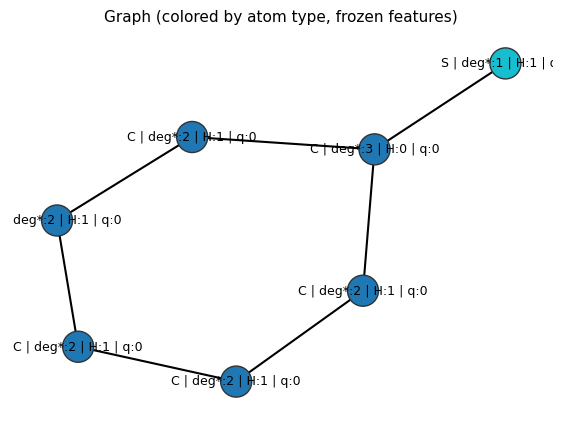

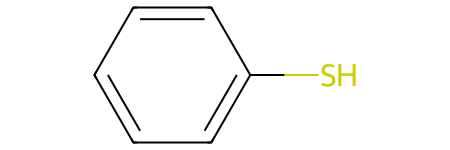

Num Atoms 7
Num Bonds 7
Is final graph:  True
[85] Original Graph


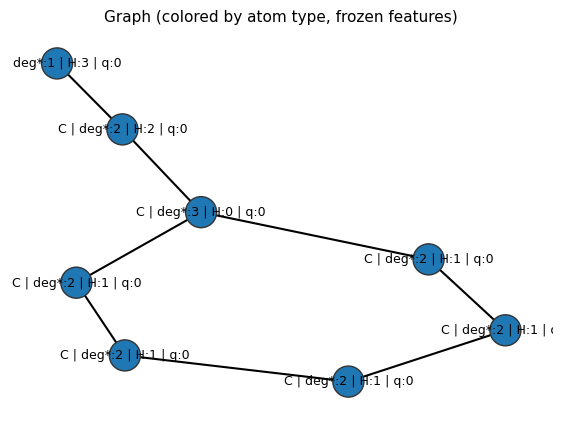

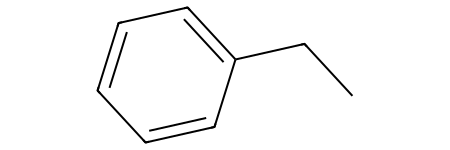

Num Nodes 8
Num Edges 8
Multiset Nodes 8
Decoding a graph with 8 nodes and 8 edges.
1
Graph Nr: 0


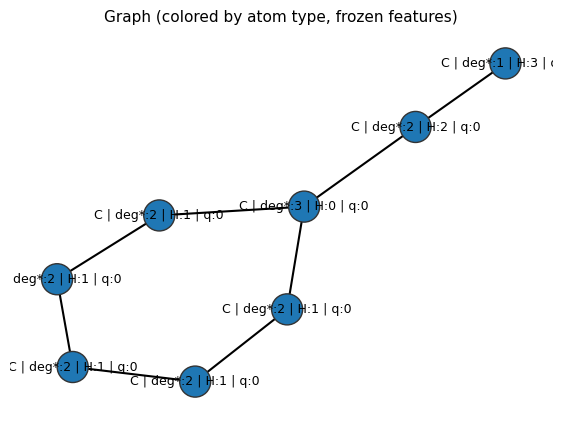

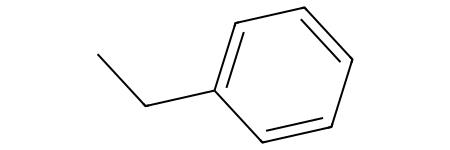

Num Atoms 8
Num Bonds 8
Is final graph:  True
[86] Original Graph


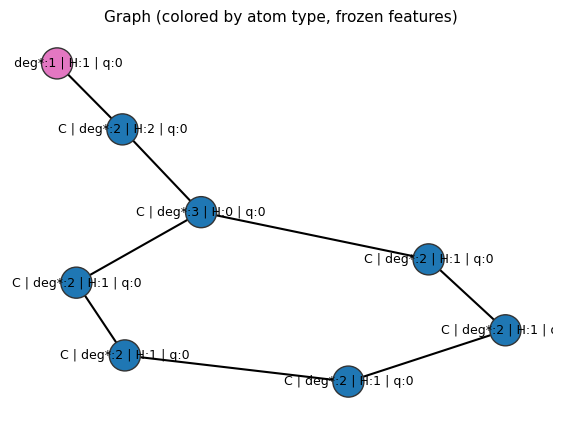

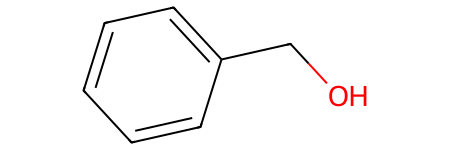

Num Nodes 8
Num Edges 8
Multiset Nodes 8
Decoding a graph with 8 nodes and 8 edges.
1
Graph Nr: 0


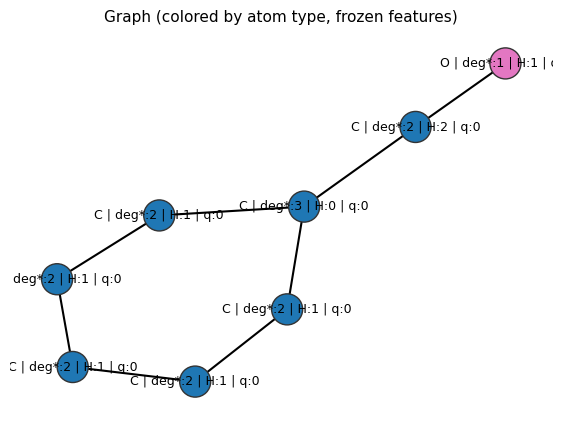

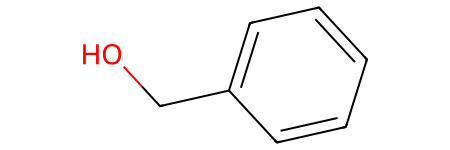

Num Atoms 8
Num Bonds 8
Is final graph:  True
[87] Original Graph


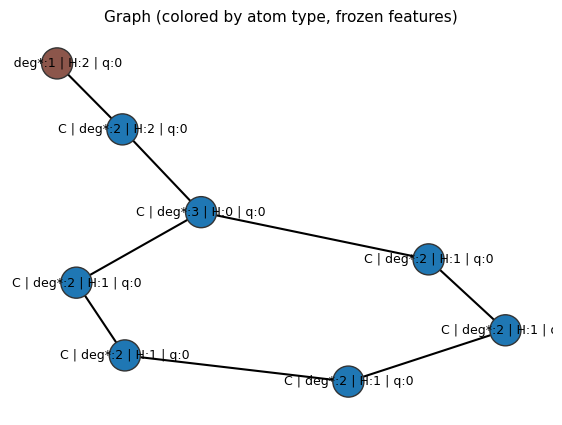

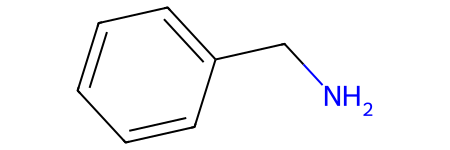

Num Nodes 8
Num Edges 8
Multiset Nodes 8
Decoding a graph with 8 nodes and 8 edges.
1
Graph Nr: 0


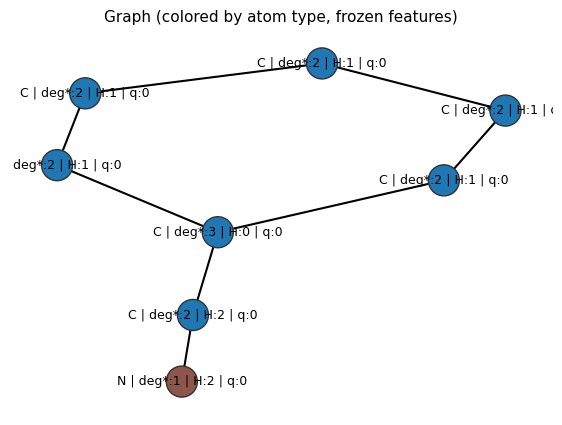

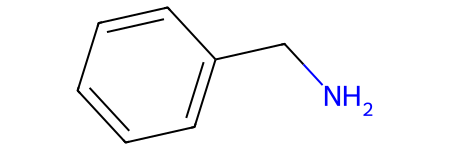

Num Atoms 8
Num Bonds 8
Is final graph:  True
[88] Original Graph


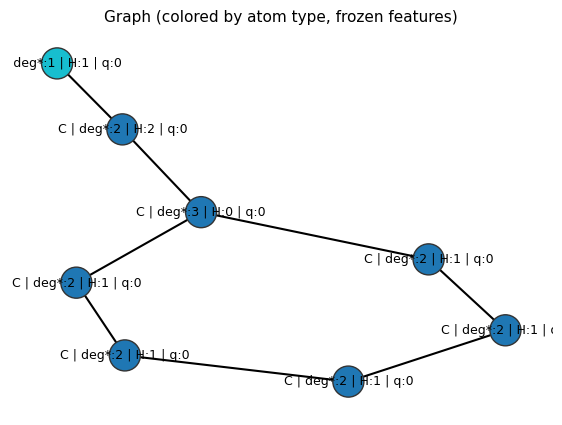

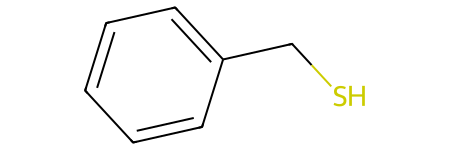

Num Nodes 8
Num Edges 8
Multiset Nodes 8
Decoding a graph with 8 nodes and 8 edges.
1
Graph Nr: 0


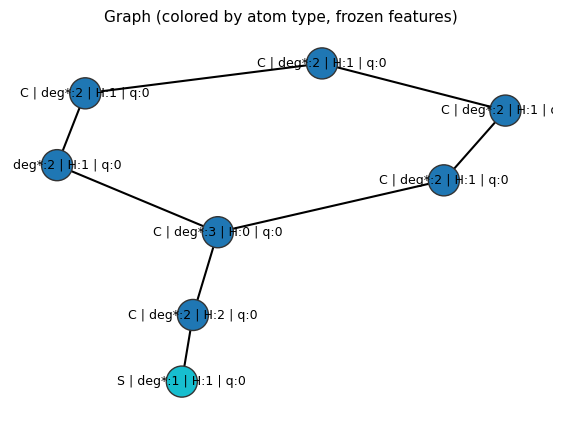

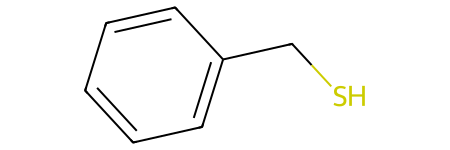

Num Atoms 8
Num Bonds 8
Is final graph:  True
[89] Original Graph


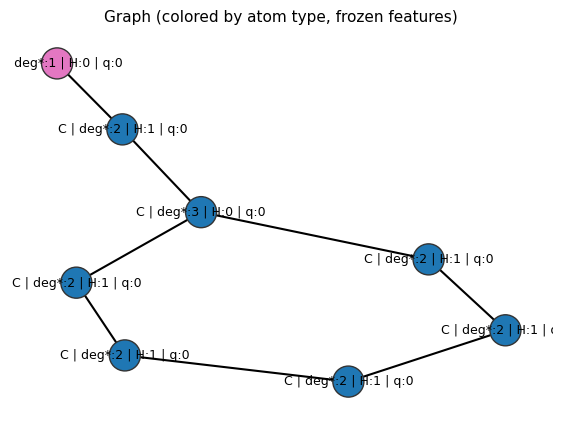

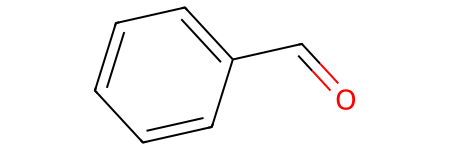

Num Nodes 8
Num Edges 8
Multiset Nodes 8
Decoding a graph with 8 nodes and 8 edges.
0
[]
No Graphs encoded ...!
[90] Original Graph


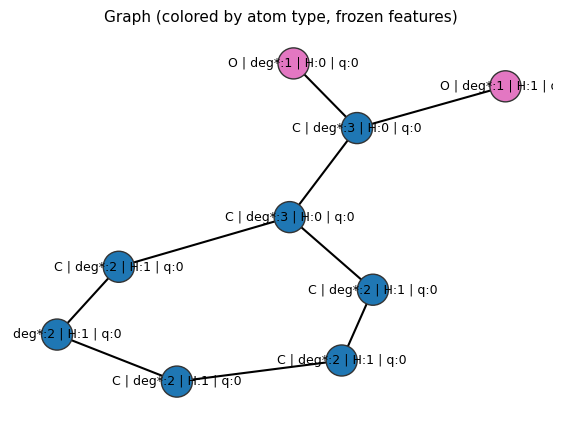

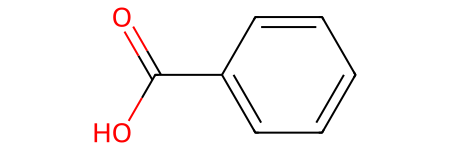

Num Nodes 9
Num Edges 9
Multiset Nodes 9
Decoding a graph with 9 nodes and 9 edges.
1
Graph Nr: 0


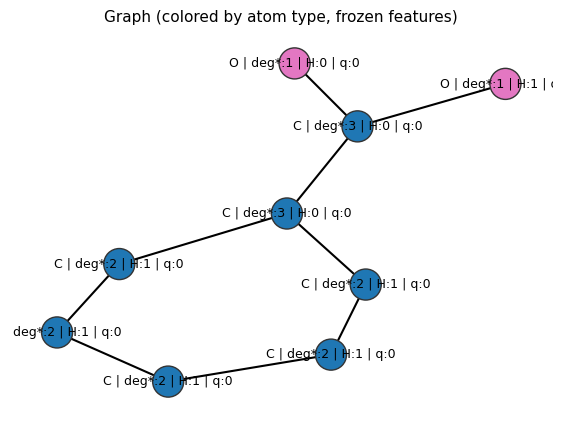

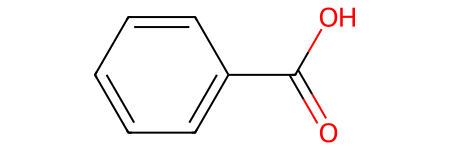

Num Atoms 9
Num Bonds 9
Is final graph:  True
[91] Original Graph


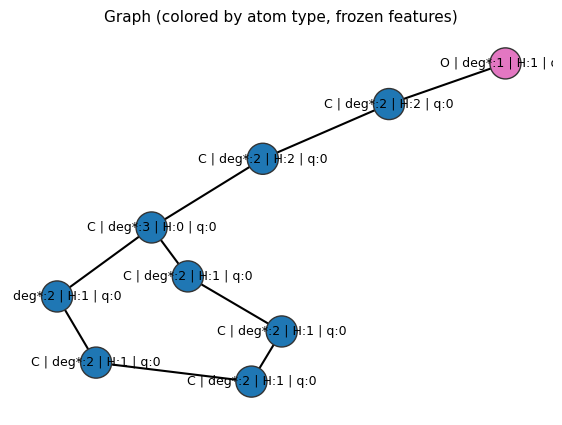

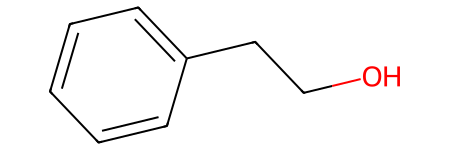

Num Nodes 9
Num Edges 9
Multiset Nodes 9
Decoding a graph with 9 nodes and 9 edges.
1
Graph Nr: 0


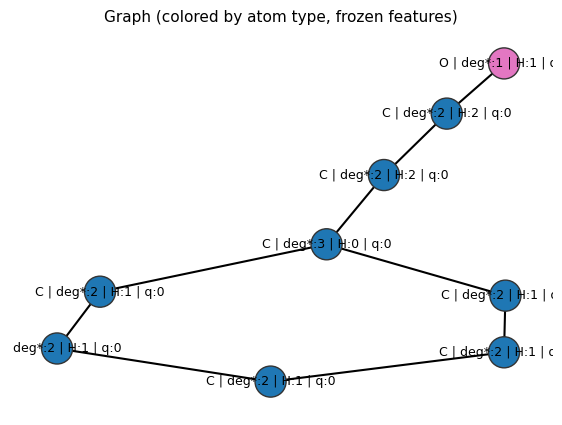

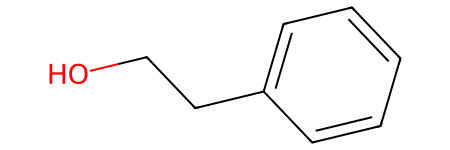

Num Atoms 9
Num Bonds 9
Is final graph:  True
[92] Original Graph


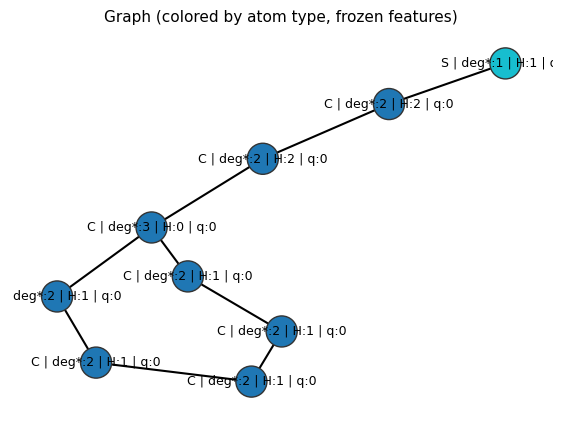

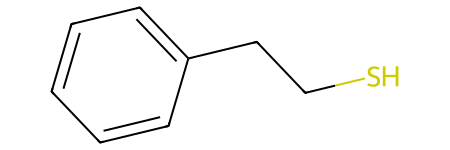

Num Nodes 9
Num Edges 9
Multiset Nodes 9
Decoding a graph with 9 nodes and 9 edges.
1
Graph Nr: 0


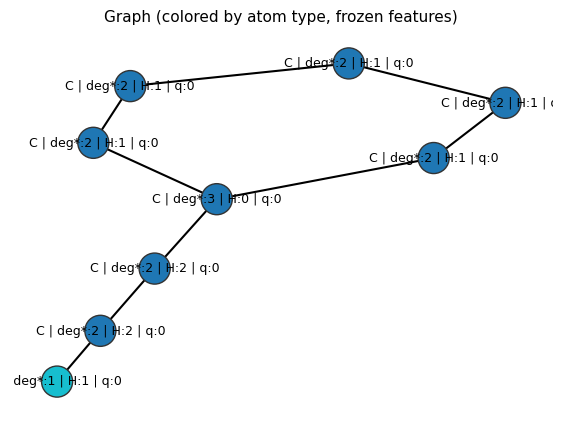

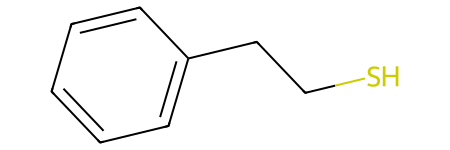

Num Atoms 9
Num Bonds 9
Is final graph:  True
[93] Original Graph


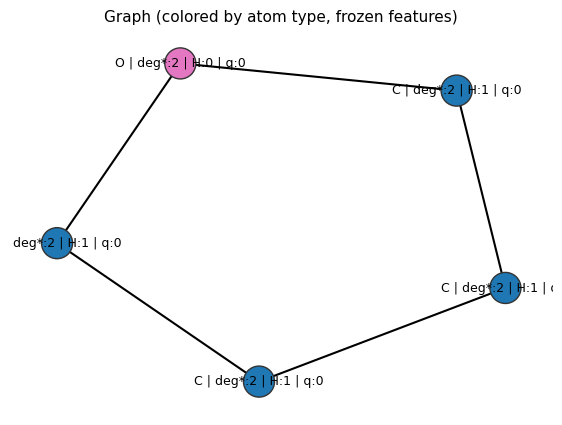

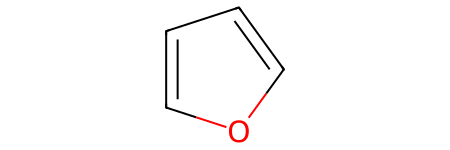

Num Nodes 5
Num Edges 5
Multiset Nodes 5
Decoding a graph with 5 nodes and 5 edges.
0
[]
No Graphs encoded ...!
[94] Original Graph


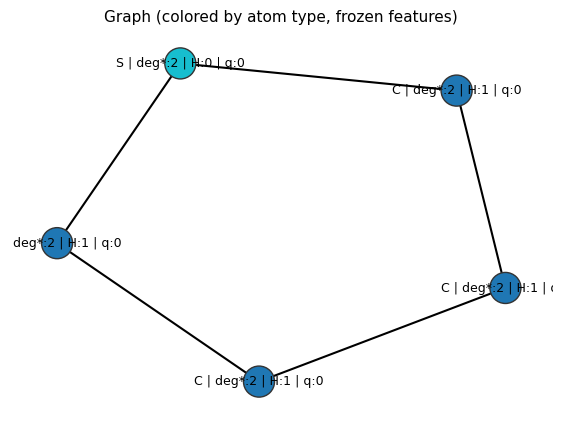

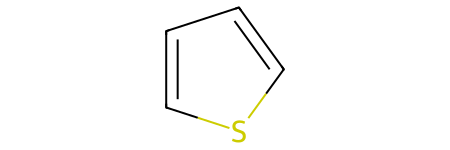

Num Nodes 5
Num Edges 5
Multiset Nodes 5
Decoding a graph with 5 nodes and 5 edges.
1
Graph Nr: 0


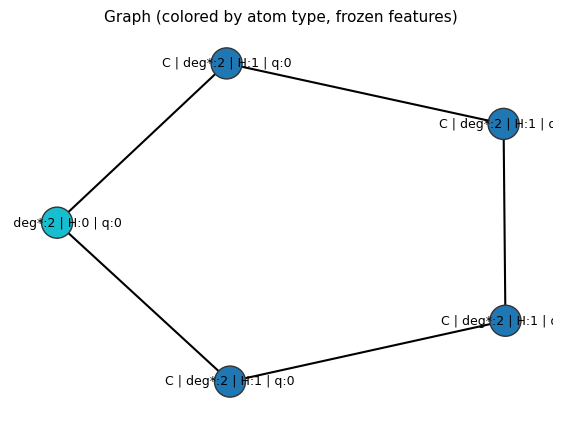

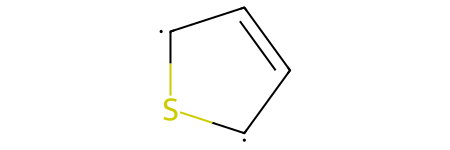

Num Atoms 5
Num Bonds 5
Is final graph:  True
[95] Original Graph


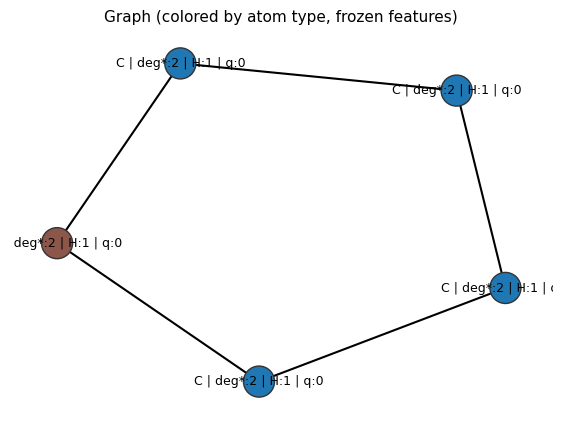

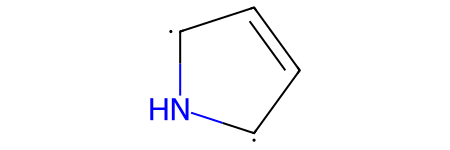

Num Nodes 5
Num Edges 5
Multiset Nodes 5
Decoding a graph with 5 nodes and 5 edges.
0
[]
No Graphs encoded ...!
Accuracy: 0.3125
96
[3, 4, 5, 6, 9, 10, 11, 12, 13, 18, 22, 23, 24, 43, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 94]


In [16]:
from src.utils import visualisations
from src.encoding.decoder import greedy_oracle_decoder
from pathlib import Path
from src.encoding.oracles import MLPClassifier, Oracle
from pprint import pprint
from src.utils.utils import DataTransformer
from torchhd import HRRTensor


# Real Oracle
def is_final_graph(G_small: nx.Graph, G_big: nx.Graph) -> bool:
    """NetworkX VF2: is `G_small` an induced, label-preserving subgraph of `G_big`?"""
    if G_small.number_of_nodes() == G_big.number_of_nodes() and G_small.number_of_edges() == G_big.number_of_edges():
        nm = lambda a, b: a["feat"] == b["feat"]
        GM = nx.algorithms.isomorphism.GraphMatcher(G_big, G_small, node_match=nm)
        return GM.subgraph_is_isomorphic()
    return False

# simple smiles correctly decoded [3, 6, 11, 13, 18, 24, 79, 80, 83, 84, 90]
batch_size = 96
zinc_smiles = ZincSmiles(split="simple")[:batch_size]
print(len(zinc_smiles))
dataloader = DataLoader(dataset=zinc_smiles, batch_size=batch_size, shuffle=False)

# Classifier
chkpt = torch.load(Path("/Users/akaveh/projects/kit/graph_hdc/_models/mlp_stratified_base_laynorm_2nd_try.pt"), map_location="cpu", weights_only=False)

cfg = chkpt["config"]
# print(f"Classifier's best metric (AUC): {chkpt['best_metric']}")
print(f"Classifier's cfg")
pprint(cfg, indent=4)

classifier = MLPClassifier(
    hv_dim=cfg.get("hv_dim"),
    hidden_dims=cfg.get("hidden_dims"),
    use_layer_norm=cfg.get("use_layer_norm"),
    use_batch_norm=cfg.get("use_batch_norm")).to(device).eval()
classifier.load_state_dict(chkpt["model_state"], strict=True)
oracle = Oracle(model=classifier)
oracle.encoder = hypernet

y = []
correct_decoded = []
for i, batch in enumerate(dataloader):
    # Encode the whole graph in one HV
    encoded_data = hypernet.forward(batch)
    node_term = encoded_data["node_terms"]
    graph_term = encoded_data["graph_embedding"]

    graph_terms_hd = graph_term.as_subclass(HRRTensor)

    ground_truth_counters = {}
    datas = batch.to_data_list()
    for j, g in enumerate(range(batch_size)):
        print("================================================")
        full_graph_nx = DataTransformer.pyg_to_nx(data=datas[g])
        print(f"[{j}] Original Graph")
        visualisations.draw_nx_with_atom_colorings(full_graph_nx)
        plt.show()
        mol_full, _ = DataTransformer.nx_to_mol(full_graph_nx)
        display(mol_full)

        print(f"Num Nodes {datas[g].num_nodes}")
        print(f"Num Edges {int(datas[g].num_edges / 2)}")
        node_multiset = DataTransformer.get_node_counter_from_batch(batch=g, data=batch)
        print(f"Multiset Nodes {node_multiset.total()}")
        nx_GS: list[nx.Graph] = greedy_oracle_decoder(node_multiset=node_multiset, oracle=oracle, full_g_h=graph_terms_hd[g], beam_size=32, oracle_threshold=0.4, strict=True)
        print(len(nx_GS))
        print(nx_GS)
        nx_GS = list(filter(None, nx_GS))
        if len(nx_GS) == 0:
            y.append(0)
            print("No Graphs encoded ...!")
            continue

        sub_g_ys = [0]
        for i, g in enumerate(nx_GS):
            print(f"Graph Nr: {i}")
            visualisations.draw_nx_with_atom_colorings(g)
            plt.show()

            mol, _ = DataTransformer.nx_to_mol(g)
            display(mol)
            print(f"Num Atoms {mol.GetNumAtoms()}")
            print(f"Num Bonds {mol.GetNumBonds()}")

            is_final = is_final_graph(g, full_graph_nx)
            print("Is final graph: ", is_final)
            sub_g_ys.append(int(is_final))
        is_final_graph_ = int(sum(sub_g_ys) >= 1)
        y.append(is_final_graph_)
        if is_final_graph_:
            correct_decoded.append(j)
        sub_g_ys = []


print(f"Accuracy: {sum(y) / len(y)}")
print(len(y))
print(correct_decoded)